In [1]:
from datetime import date
from nsepy import get_history
import pandas as pd

In [2]:
def obtain_data(ticker,start,end):
# Enter the start and end dates using the method date(yyyy,m,dd)    
    stock=get_history(symbol=ticker,start=start,end=end)
    df=stock.copy()
    df=df.reset_index()
    df=df.drop(['Series','Prev Close','Last','Turnover','%Deliverble','Trades'],axis=1)
    df=df.rename({'Open':'open_price','Close':'close_price','High':'high','Low':'low','Volume':'volume'},axis='columns')
    df.index=df.Date
    return df

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

In [4]:
"""This cell defineds the plot_candles function"""

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['open_price']
    close_price = pricing['close_price']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
#     print('oc_min', oc_min)
#     print('oc_max', oc_max)
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]},figsize=(7,7))
    else:
        fig, ax1 = plt.subplots(1, 1)
    if title:
        ax1.set_title(title)
    fig.tight_layout()
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x , low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(True)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    ax1.set_yticklabels([])
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    if volume_bars:
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(True)
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])
    return fig    

Down 0 4
Up 12 4
Down 15 4
Down 16 3
Down 17 2
Down 18 1
Up 19 2
Up 20 3
Up 22 4
Up 24 2
Up 25 1
Down 27 4
Down 28 3
Up 34 3
Up 35 2
Up 41 4
Up 42 3
Up 43 2
Up 49 3
Up 51 2
Up 56 3
Up 57 3
Up 59 4
Up 62 4
Down 66 3
Down 81 4
Down 82 3
Down 83 2
Up 87 4
Up 88 3
Up 89 1
Up 90 2
Up 91 1
Up 92 2
Up 117 4
Down 123 4
Down 124 3
Down 125 2
Down 126 1
Up 127 1
Down 128 1
Down 133 4
Down 134 2
Down 135 1
Down 136 3
Down 137 3
Down 138 2
Down 139 1
Up 140 1
Up 147 3
Up 148 3
Up 149 2
Down 151 1
Down 154 4
Down 155 3
Down 156 2
Down 157 1
Up 158 2
Up 159 1
Up 165 4
Up 166 2
Up 167 2
Up 173 4
Up 174 3
Up 175 2
Up 176 1
Up 177 1
Down 182 4
Up 191 3
Up 192 2
Up 202 4
Up 203 3
Up 204 2
Down 221 3
Down 244 4
Down 245 3
Down 246 2
Down 247 1
Up 248 4
Up 249 4
Up 261 4
Up 262 3
Up 263 2
Up 264 1
Up 267 4
Up 268 2
Up 269 2
Up 270 4
Up 271 3
Down 283 4
Down 284 3
Down 285 2
Down 286 1
Down 287 3
Down 289 1
Down 290 3
Down 291 2
Down 292 1
Down 293 2
Down 294 1
Up 295 1
Down 296 1
Down 297 1
Down 298 1
Dow

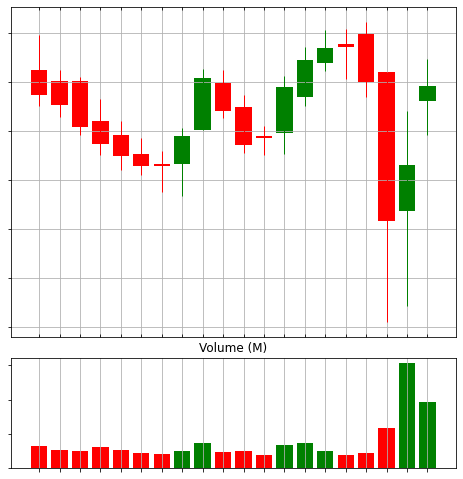

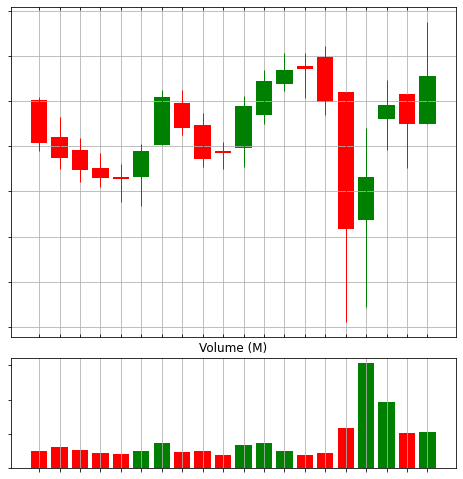

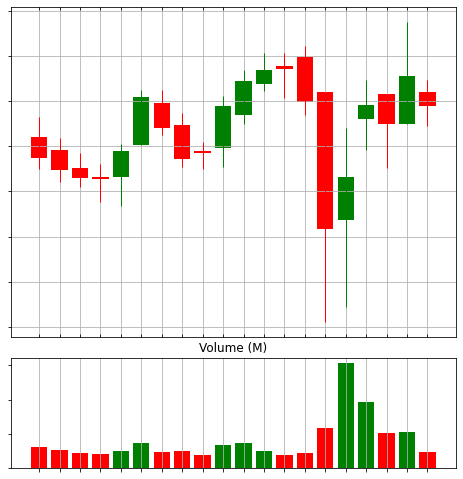

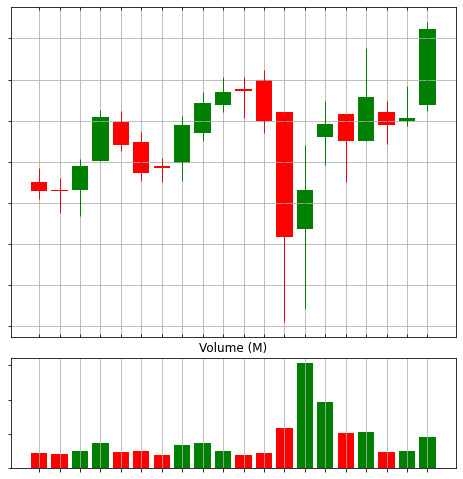

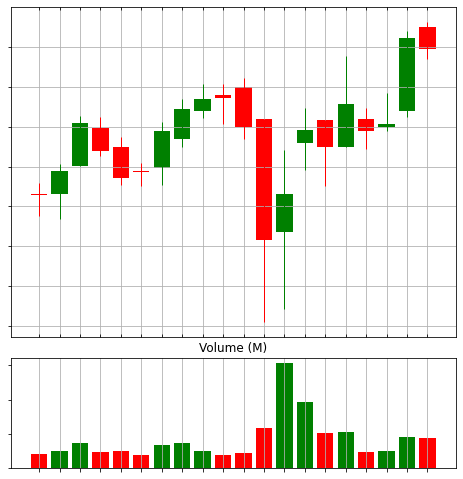

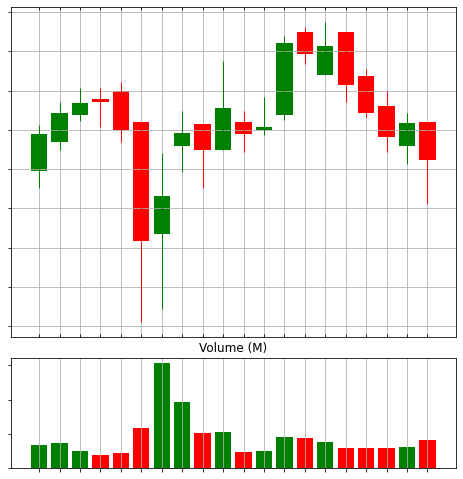

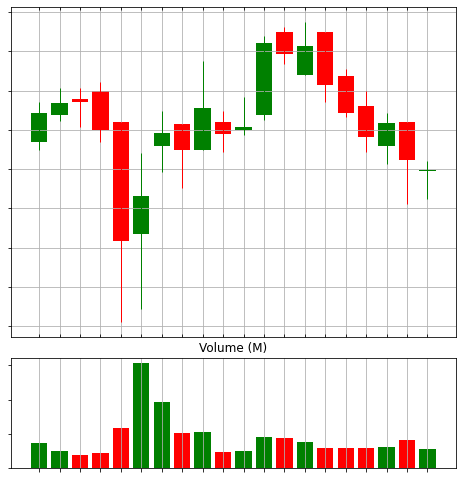

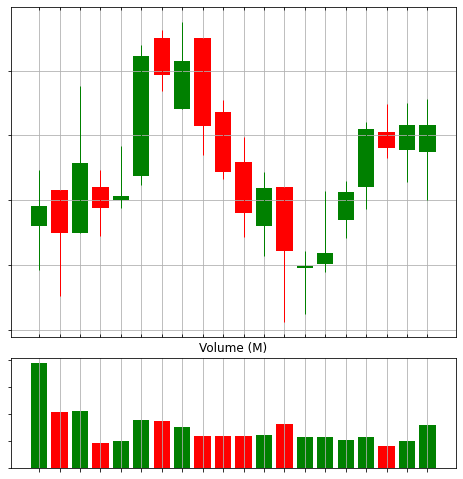

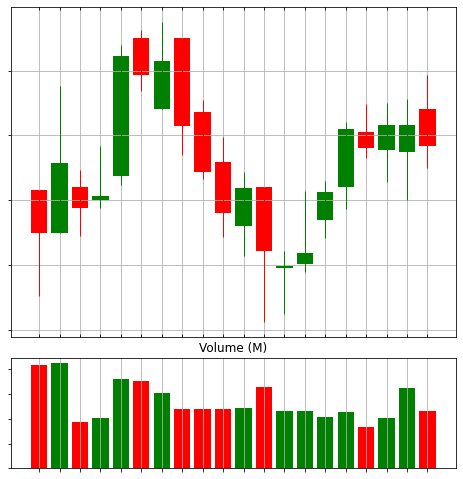

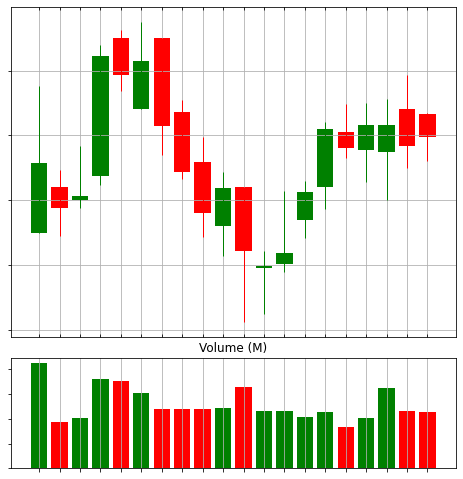

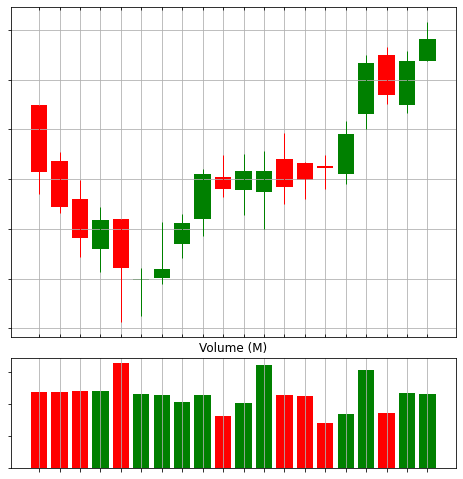

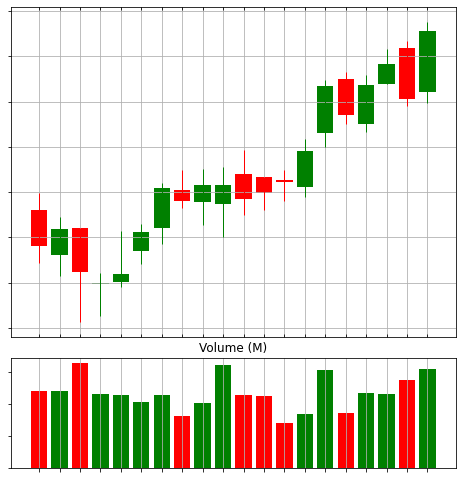

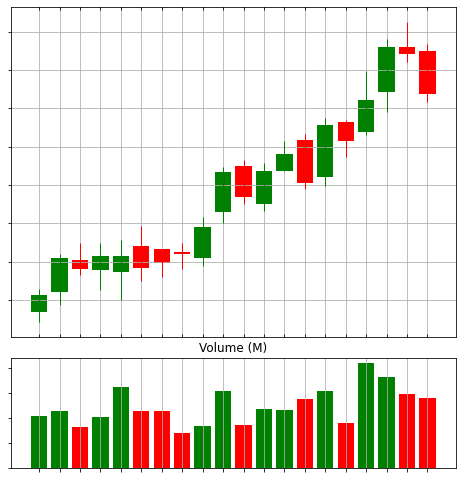

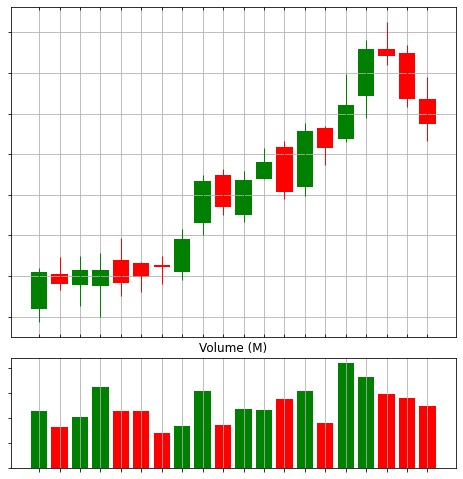

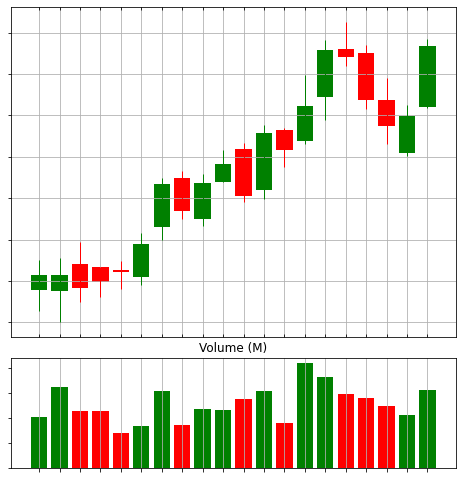

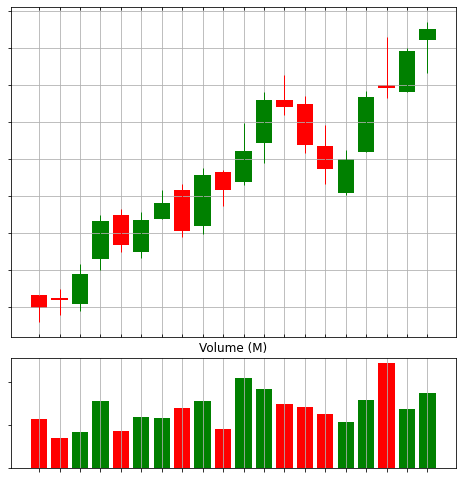

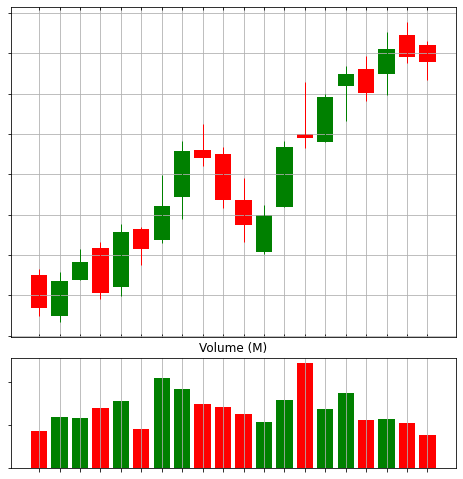

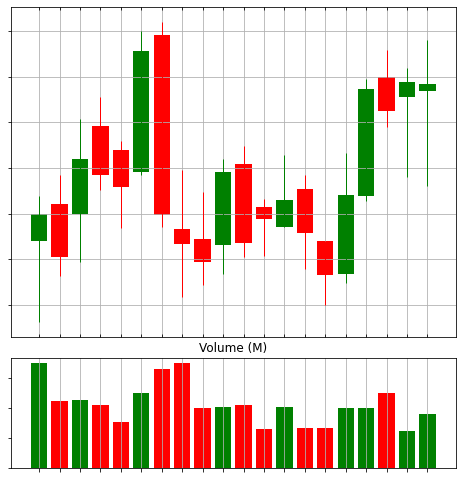

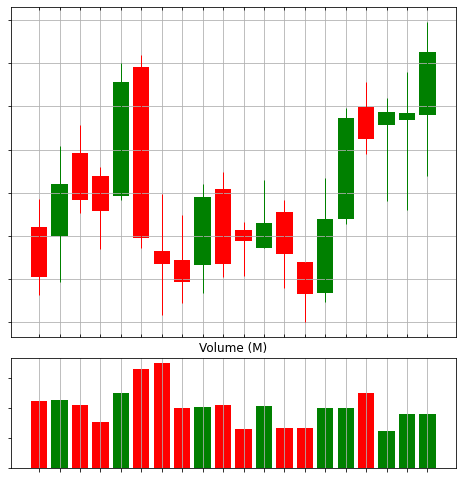

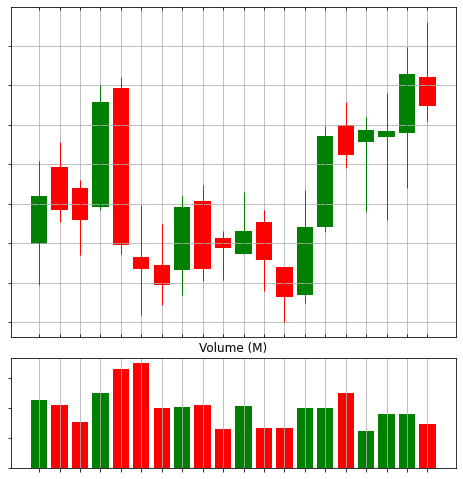

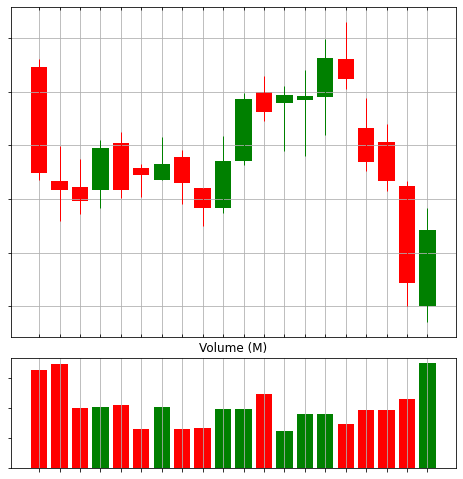

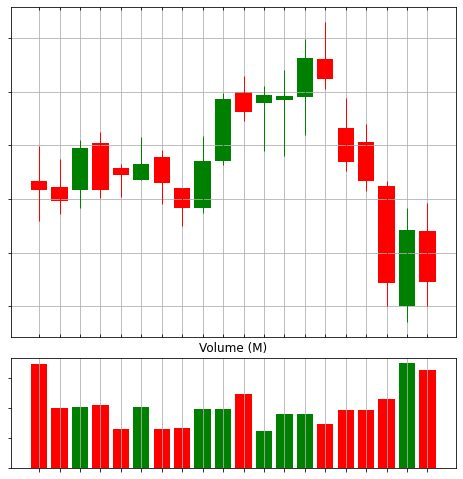

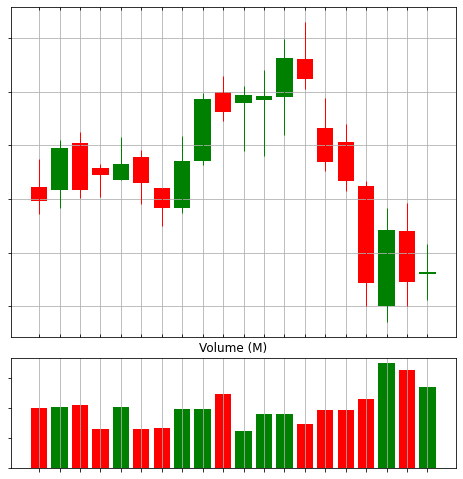

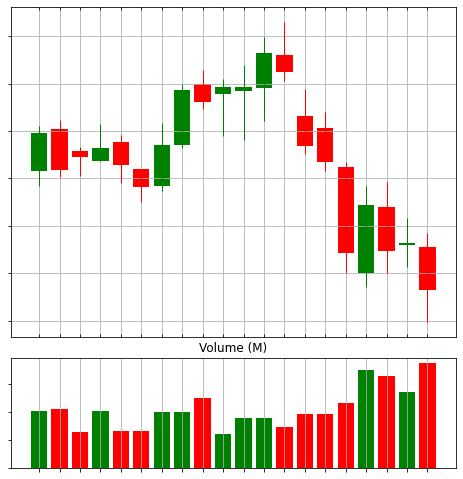

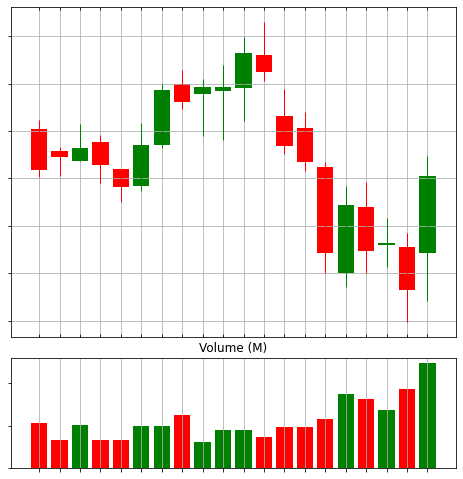

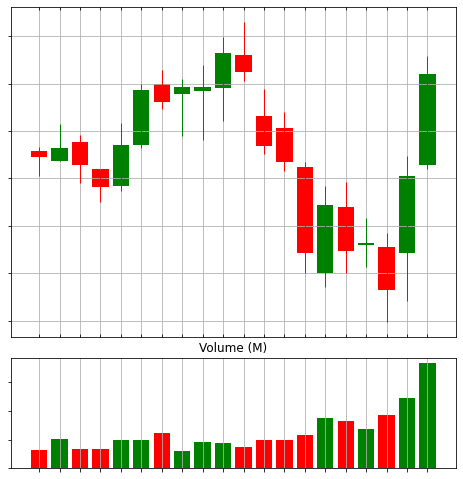

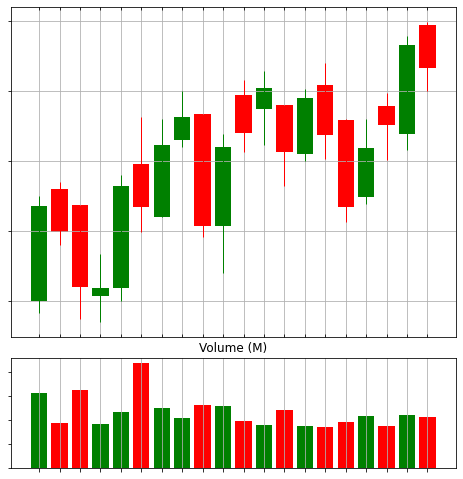

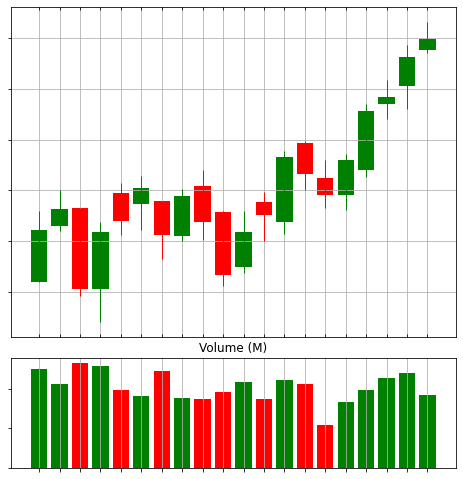

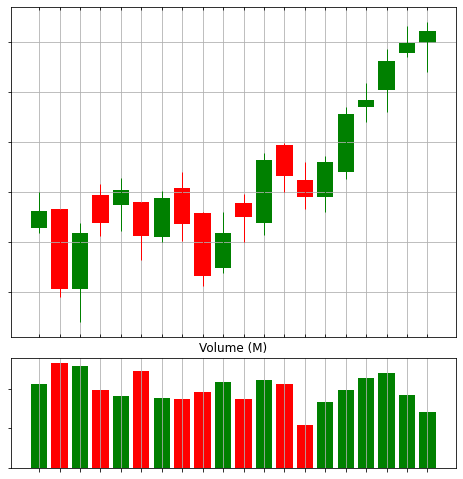

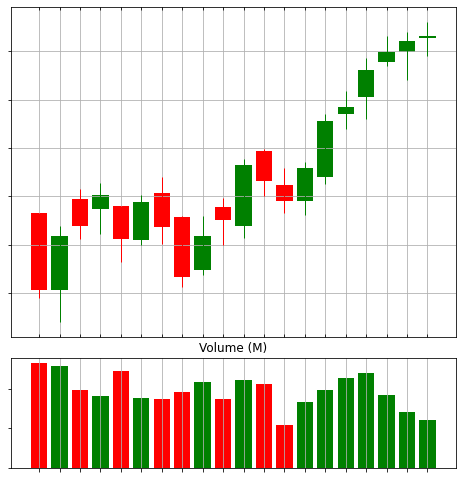

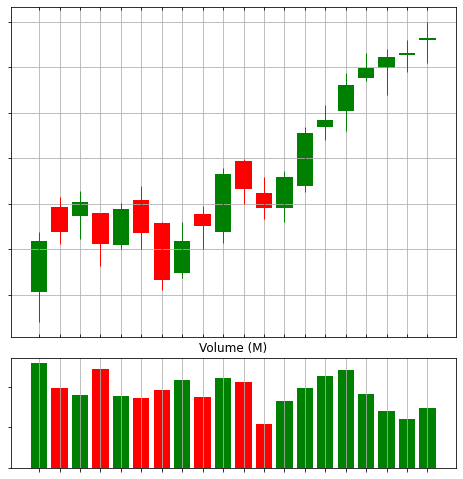

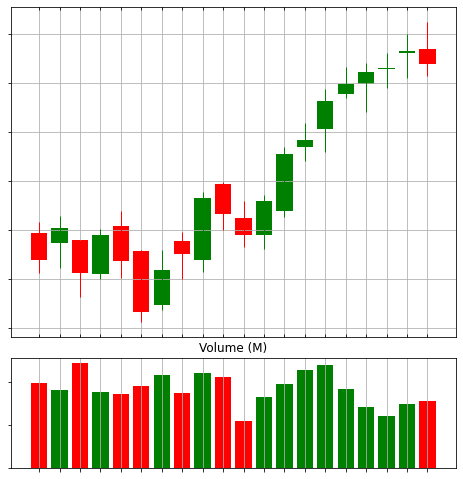

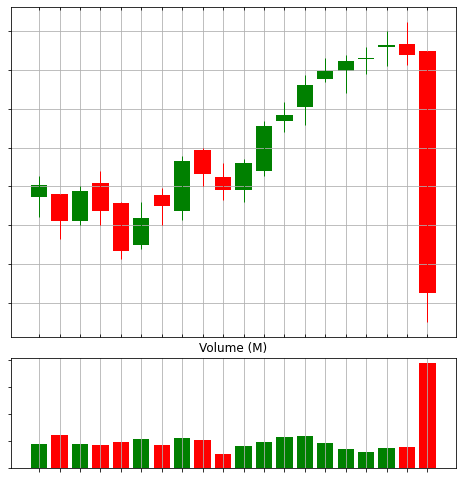

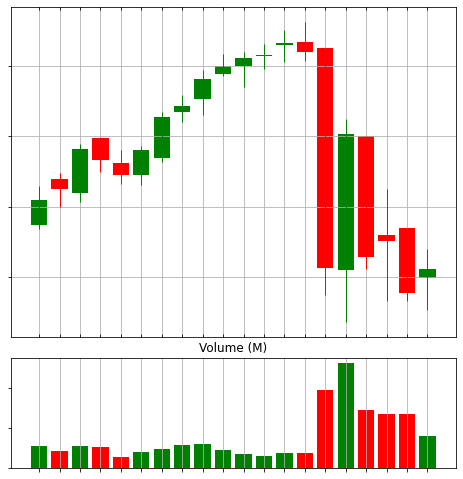

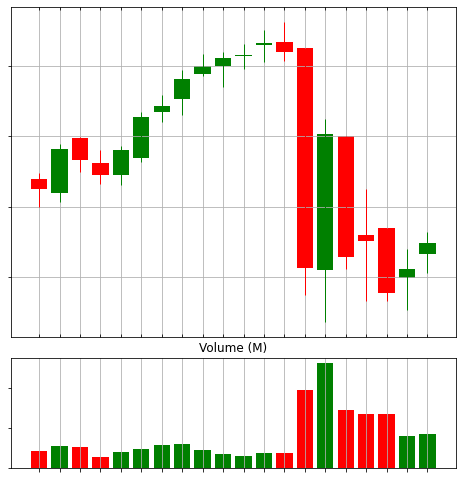

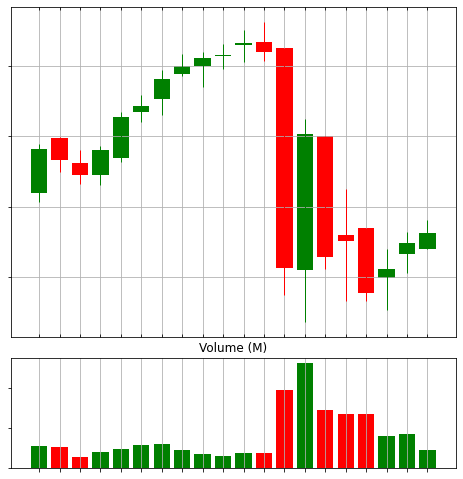

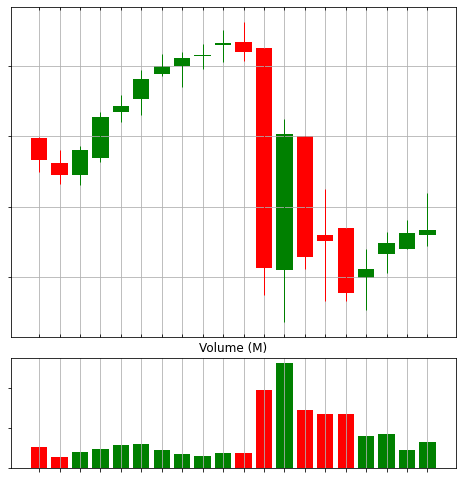

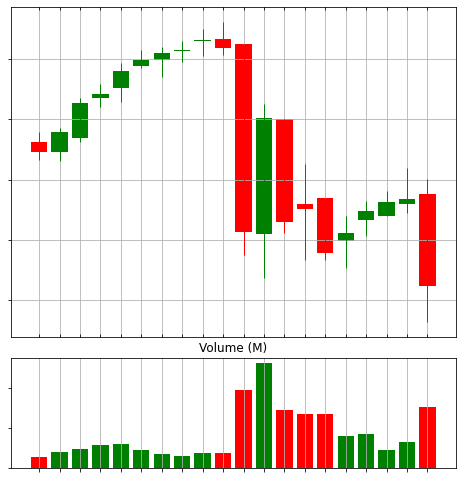

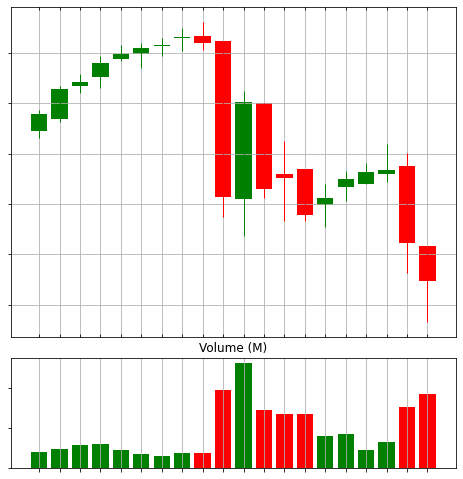

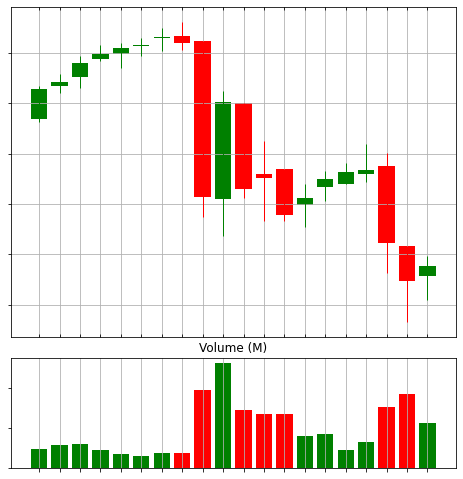

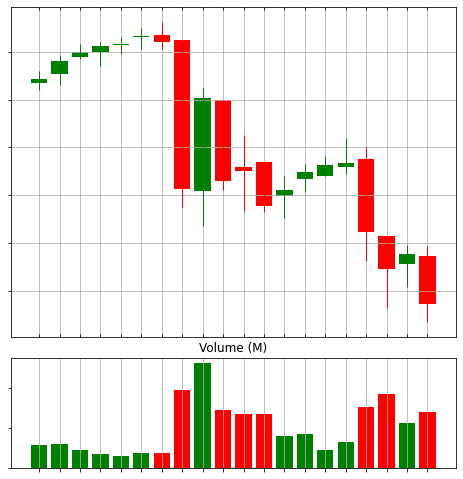

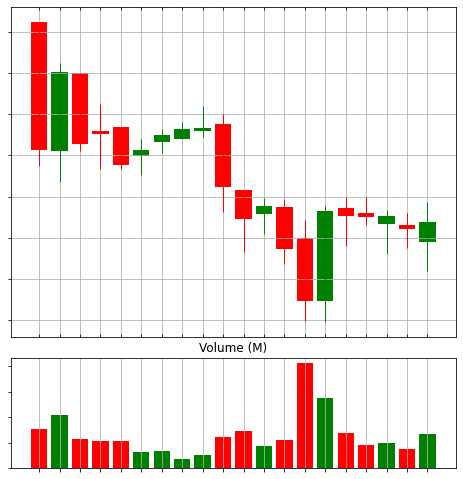

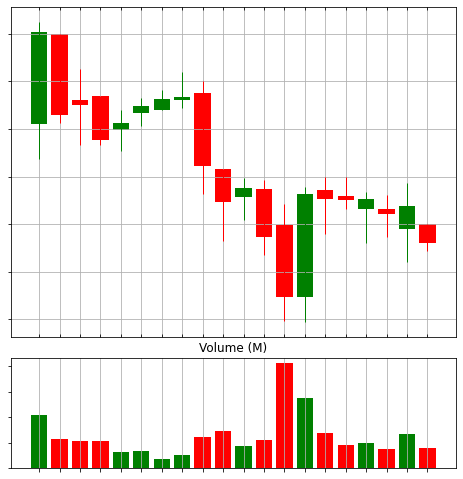

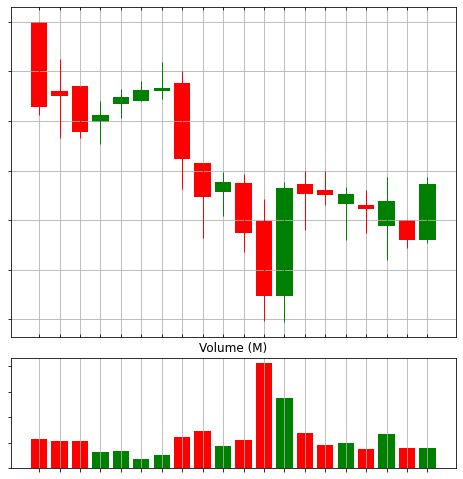

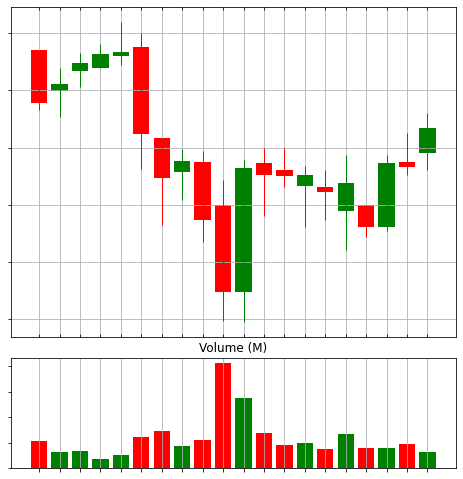

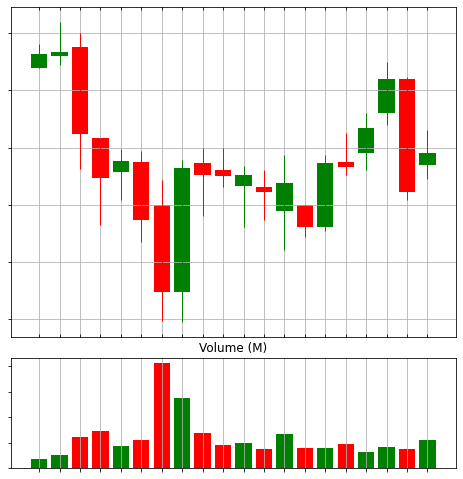

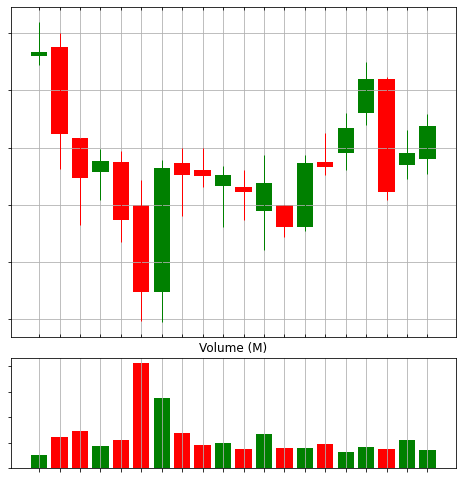

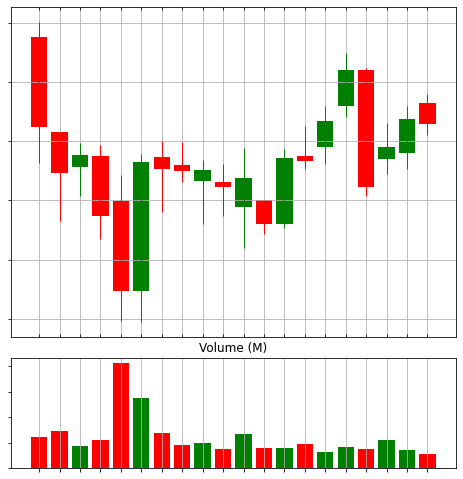

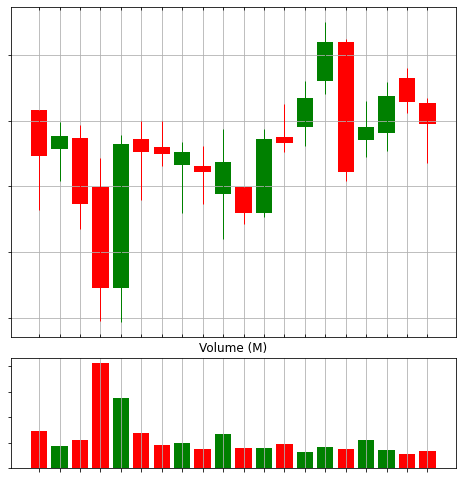

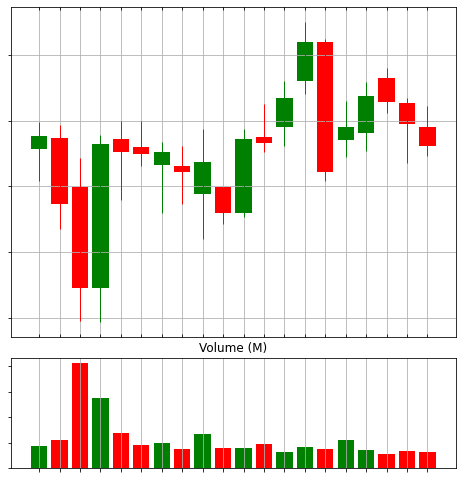

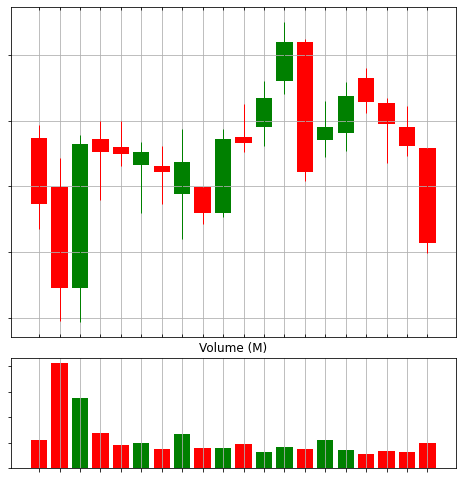

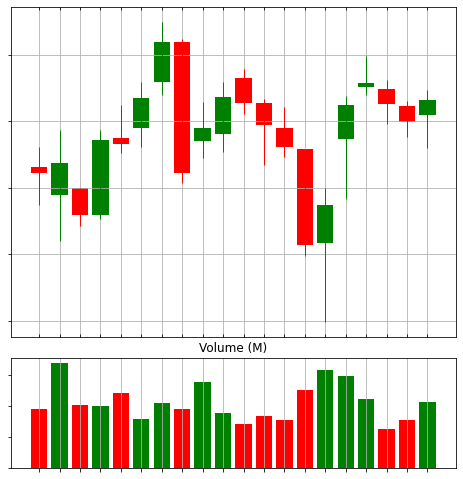

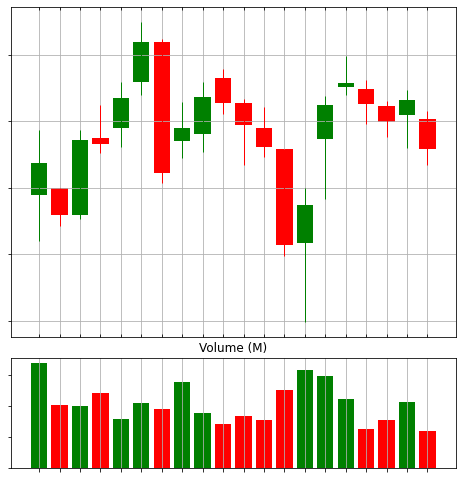

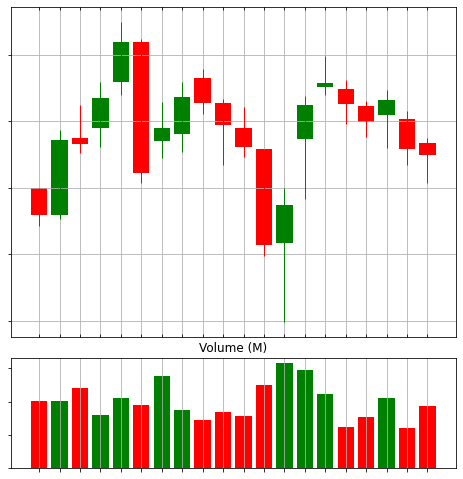

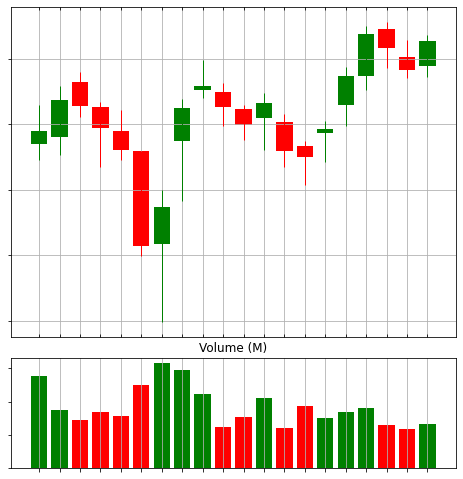

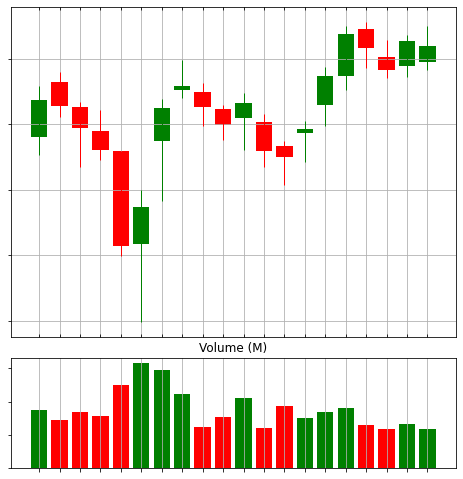

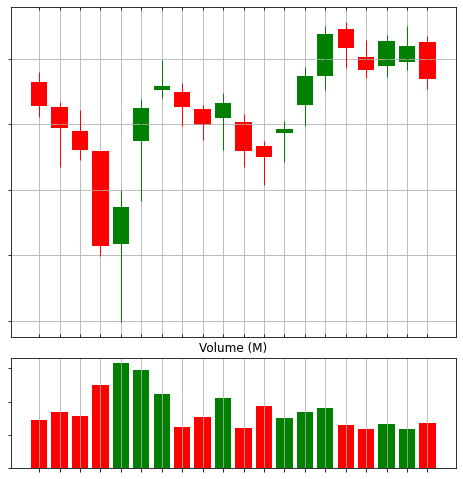

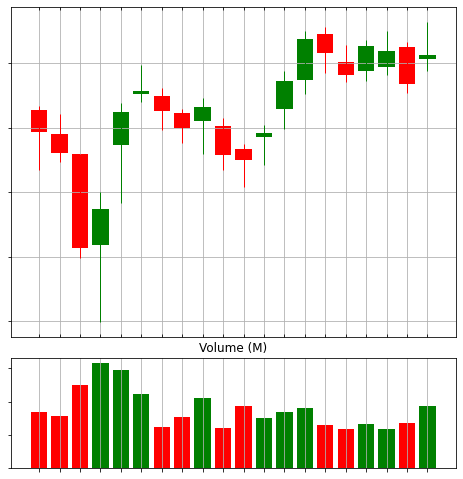

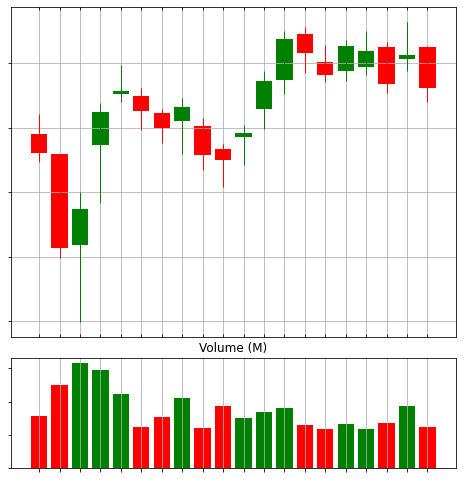

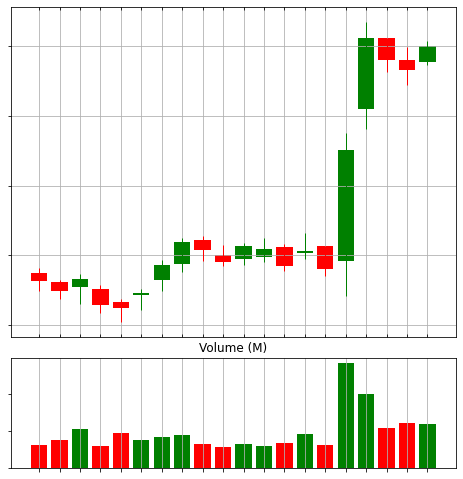

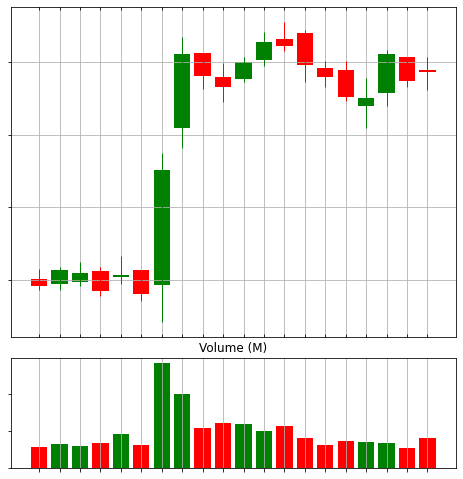

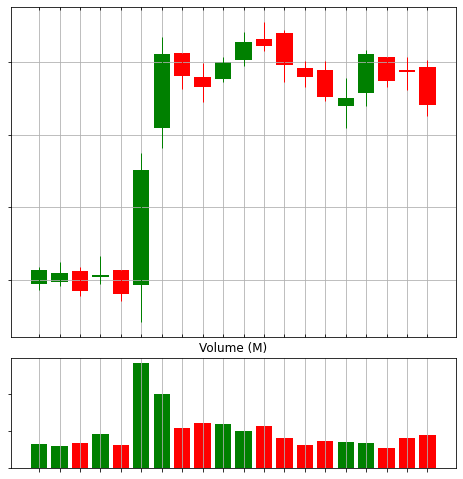

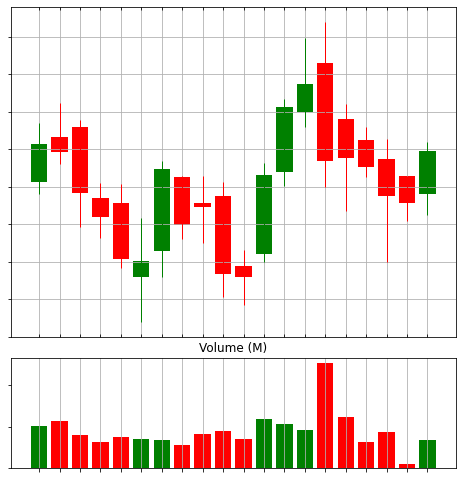

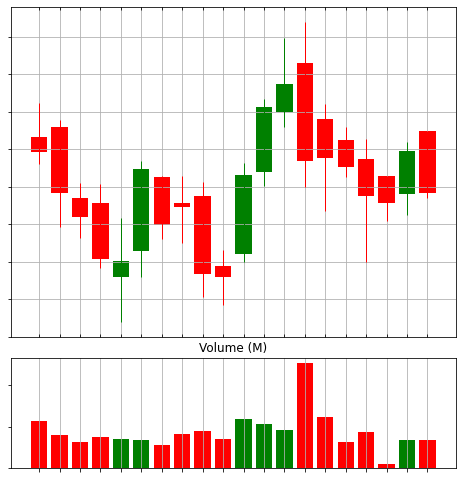

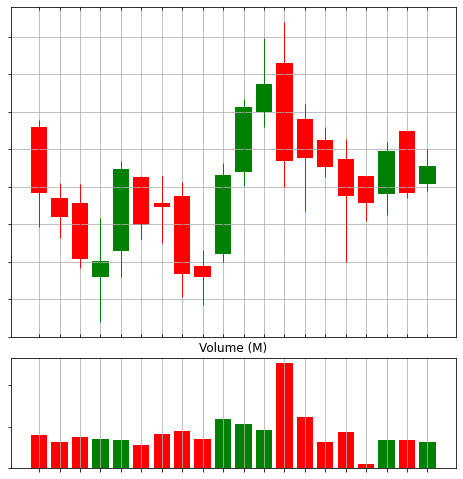

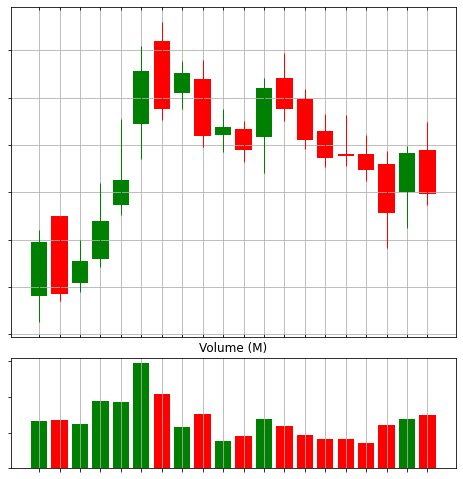

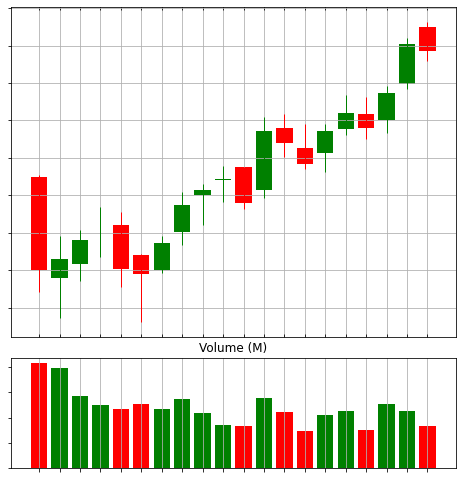

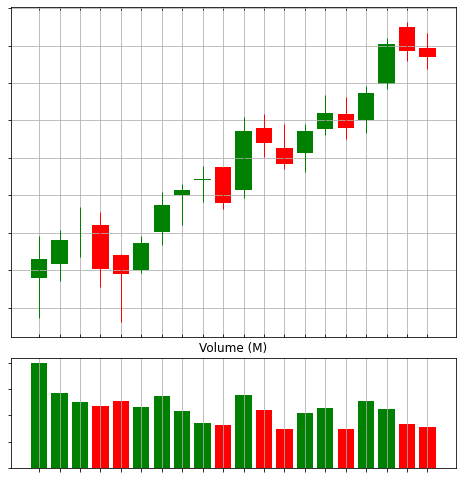

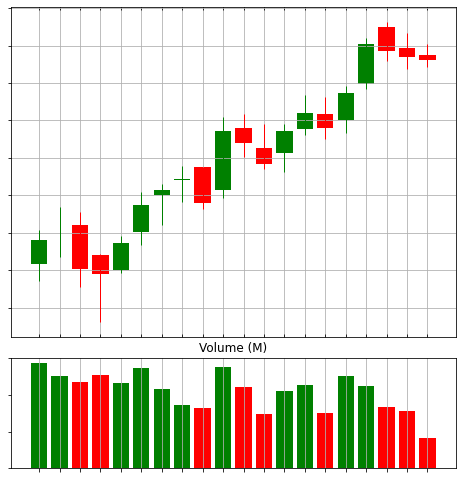

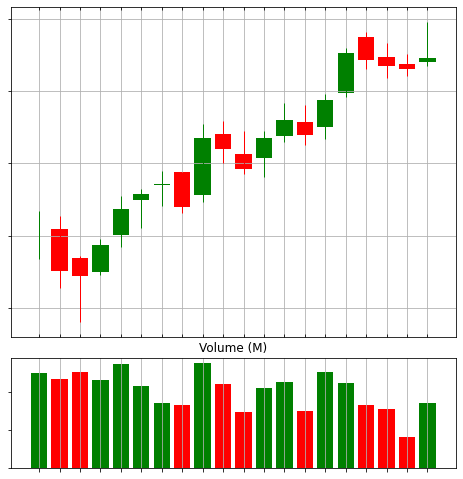

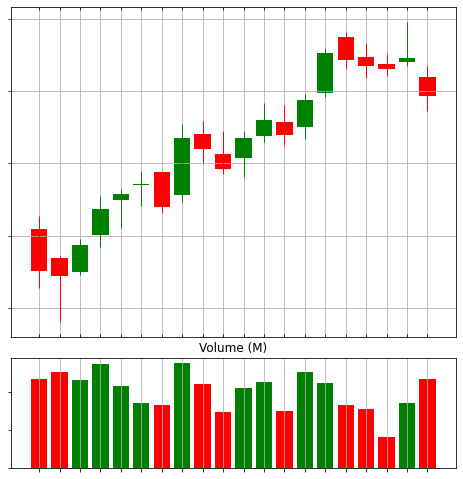

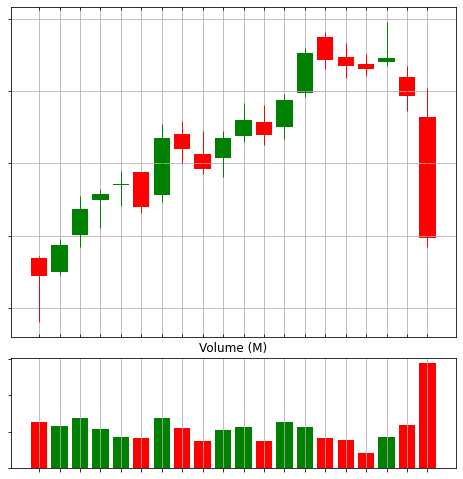

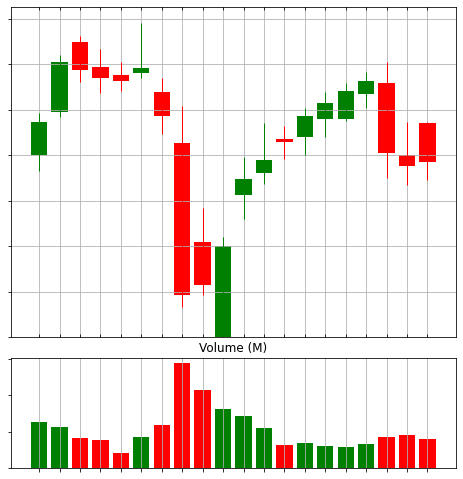

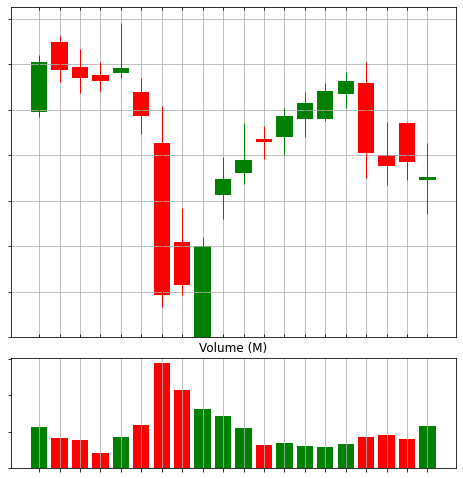

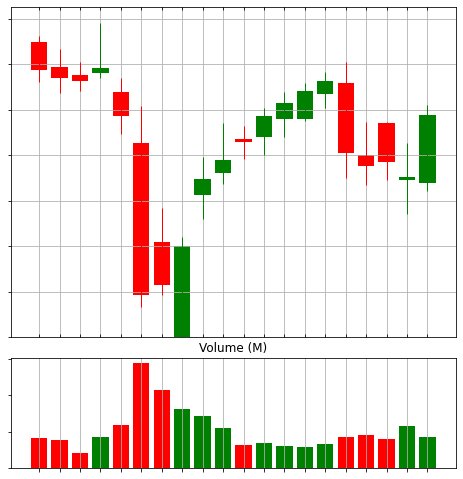

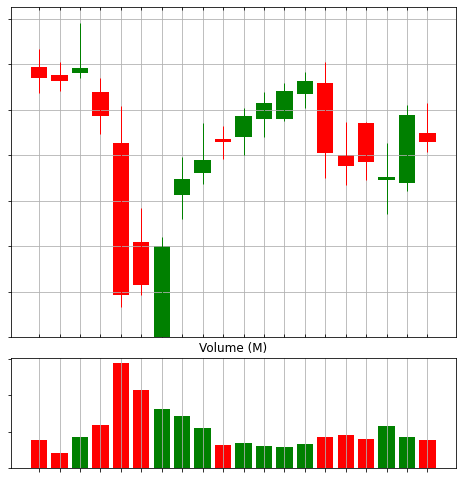

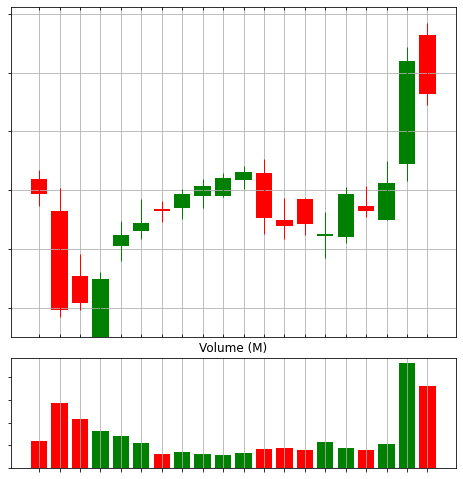

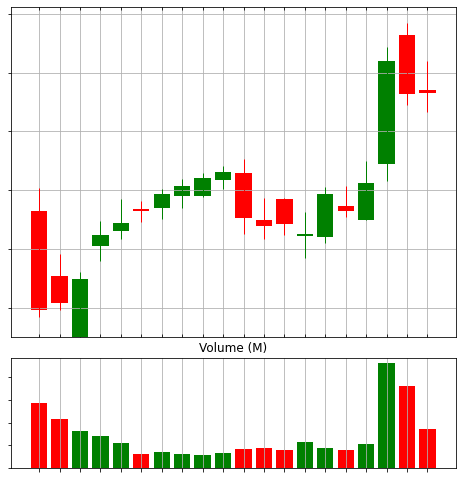

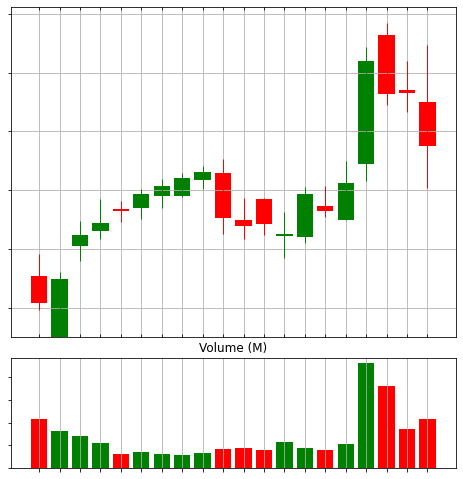

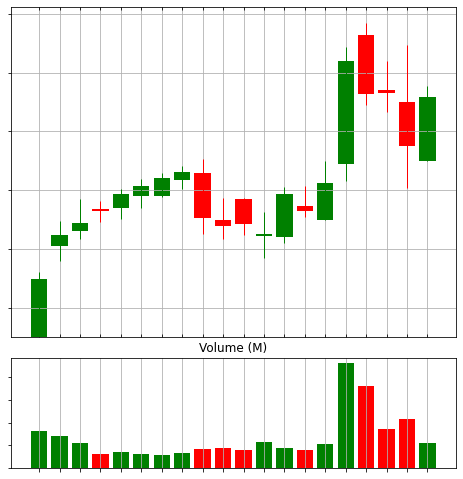

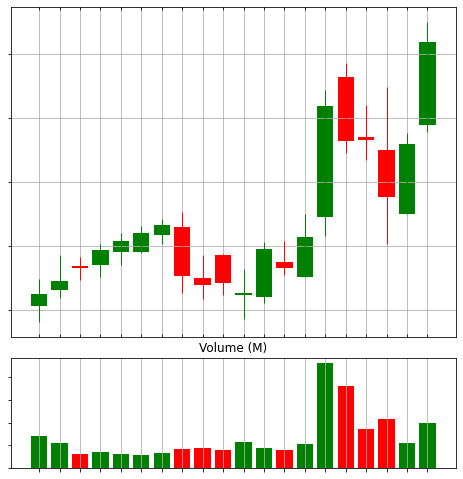

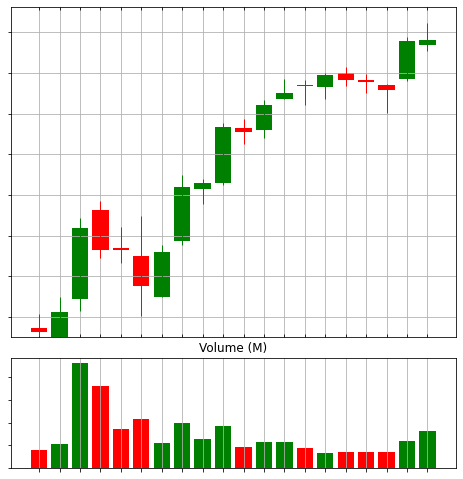

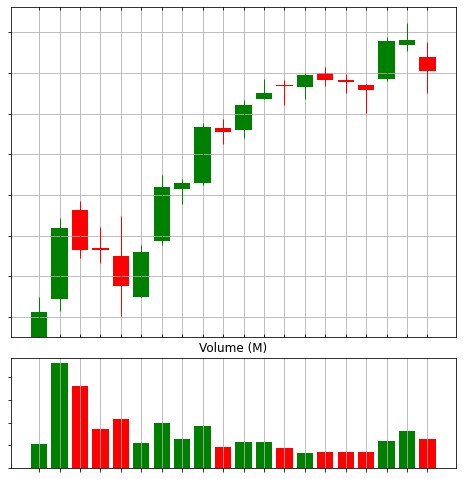

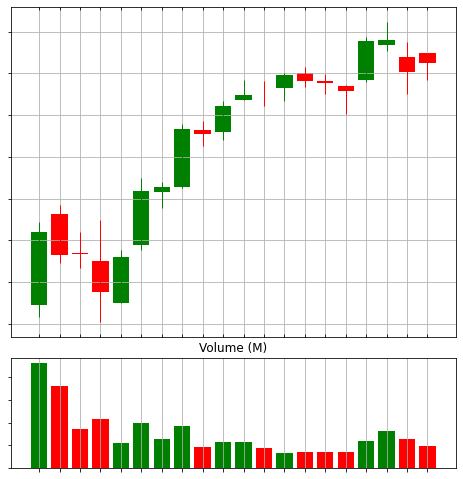

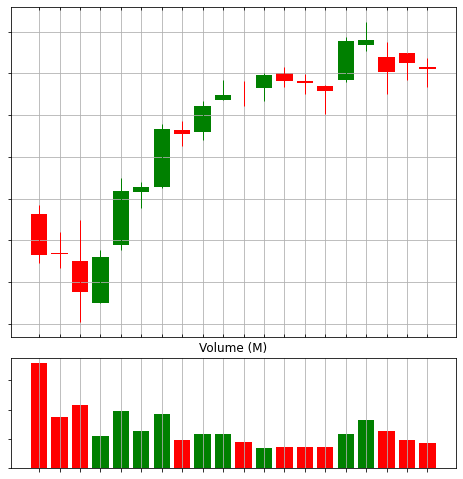

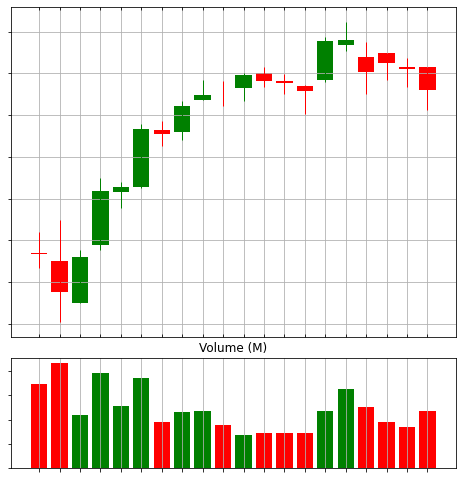

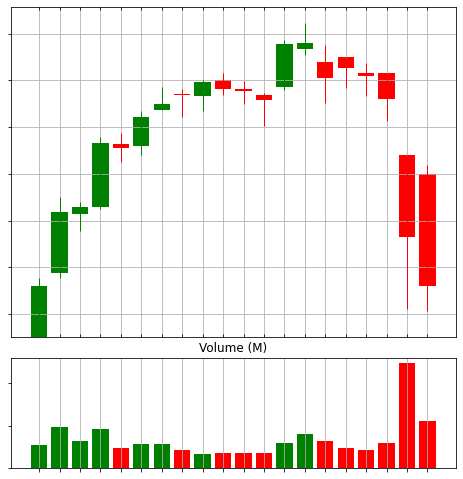

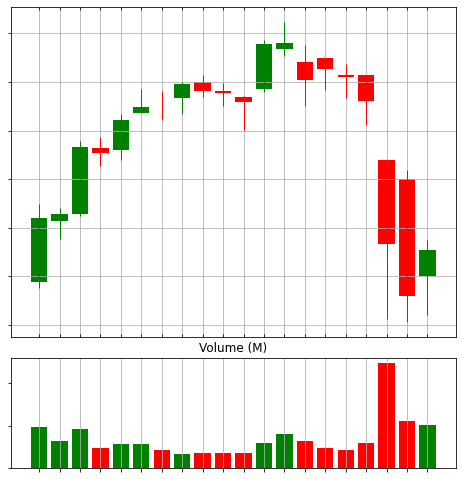

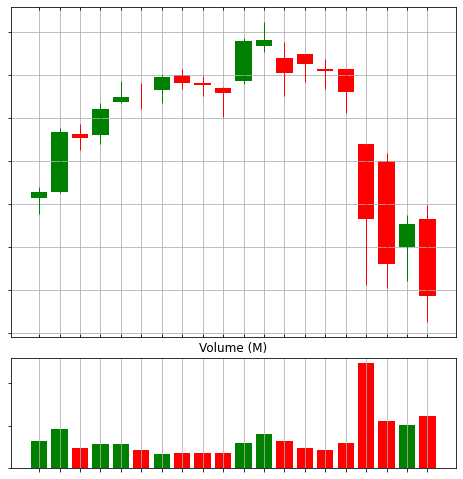

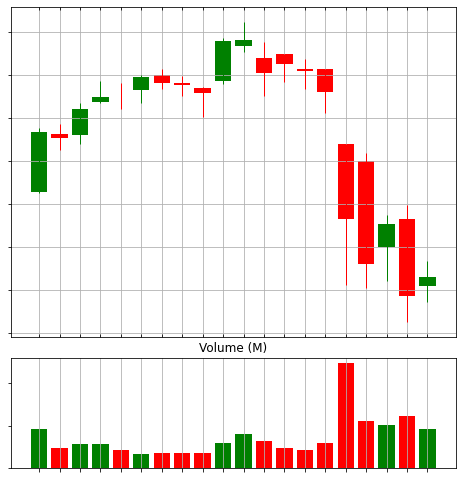

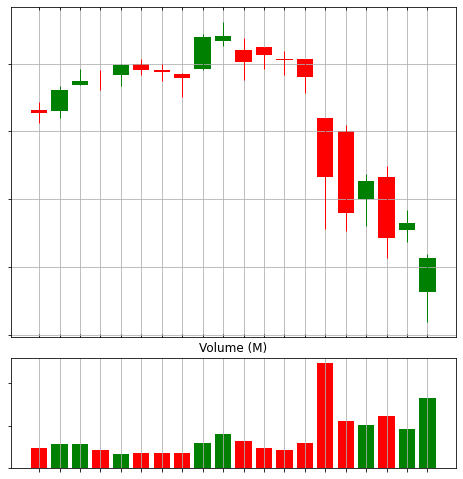

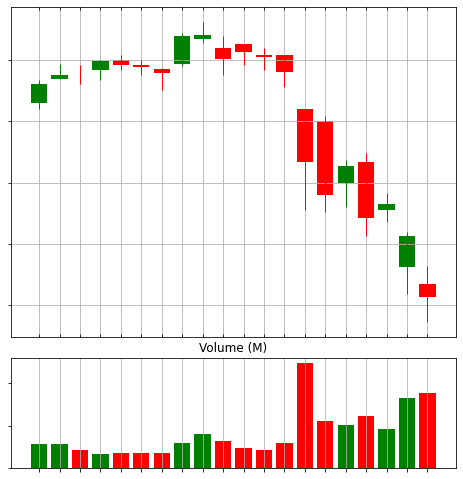

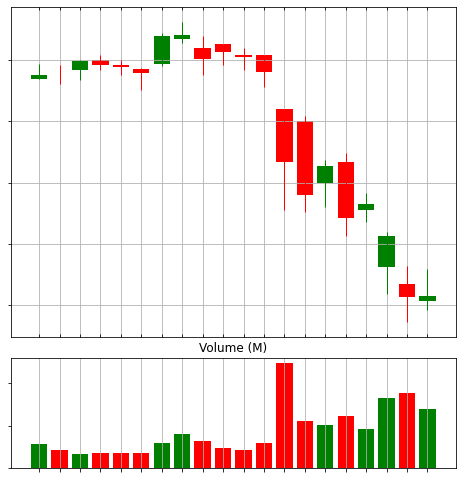

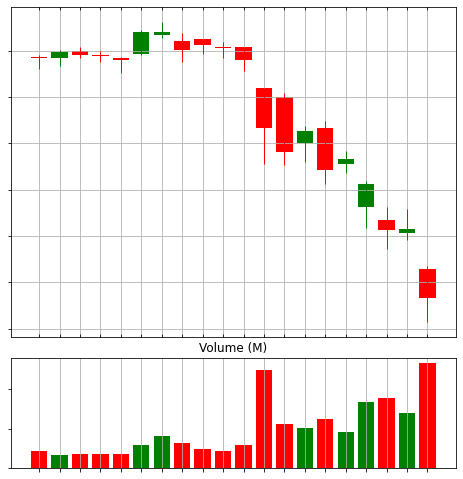

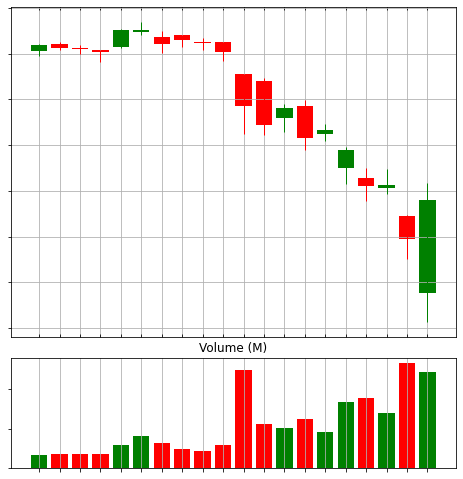

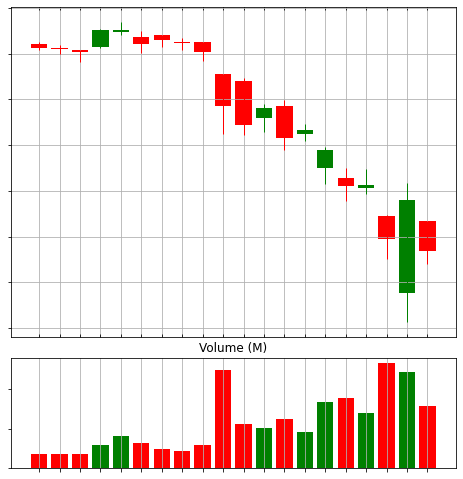

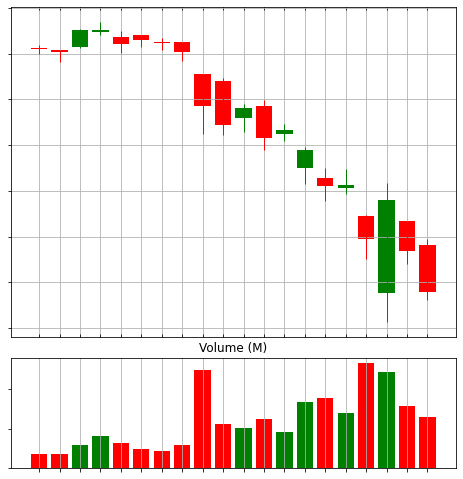

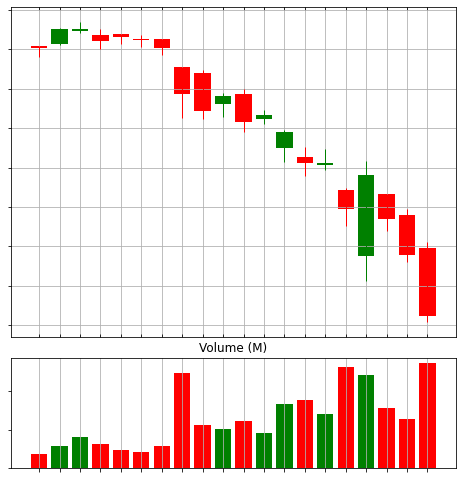

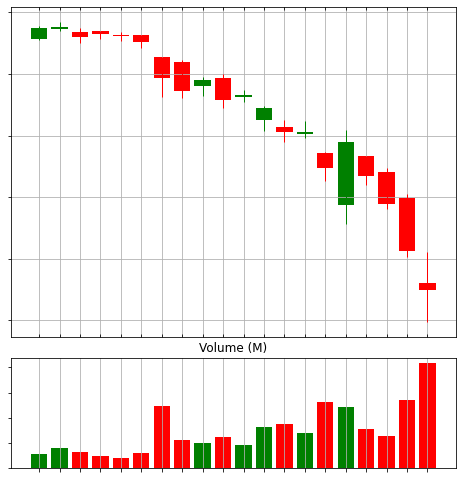

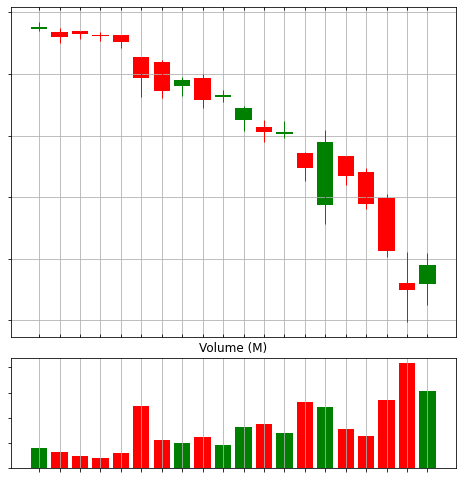

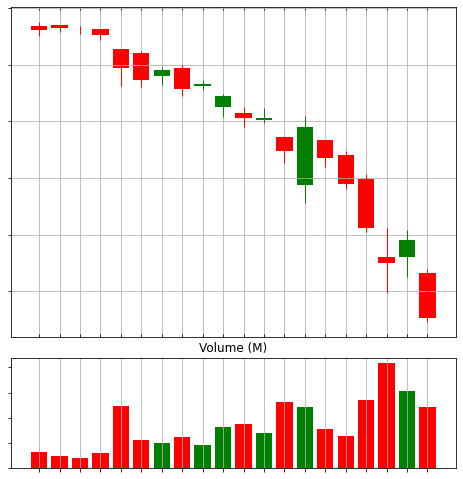

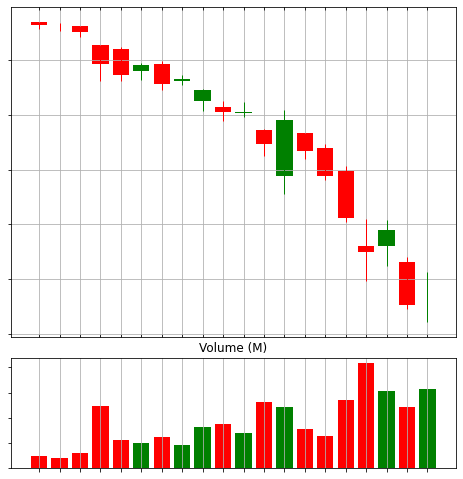

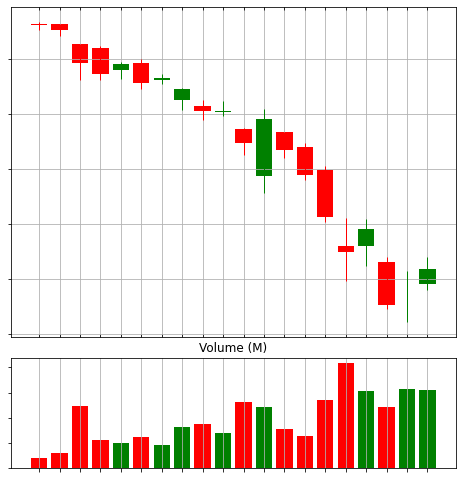

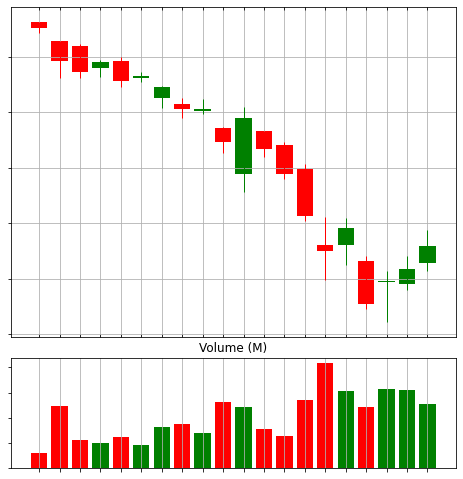

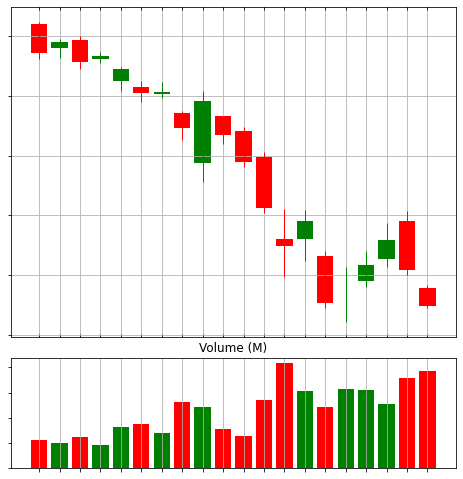

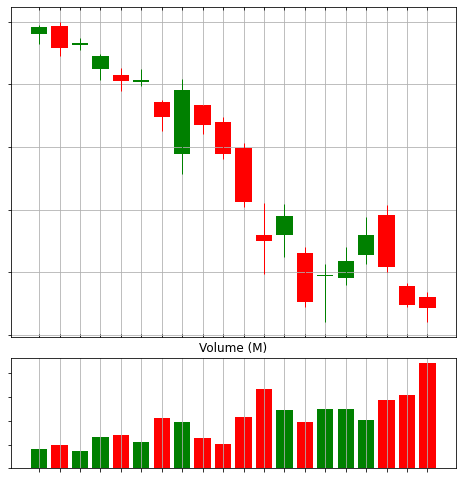

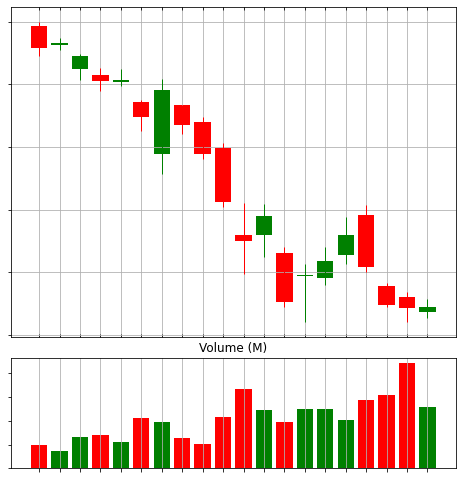

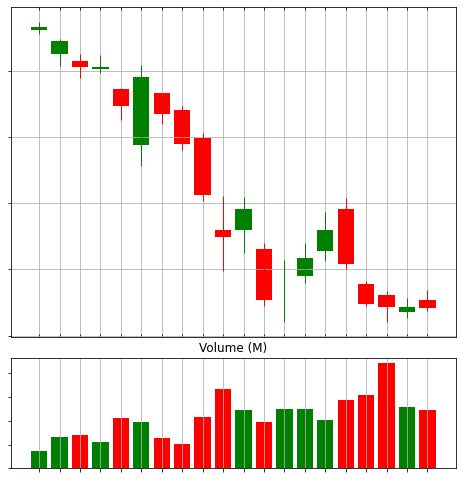

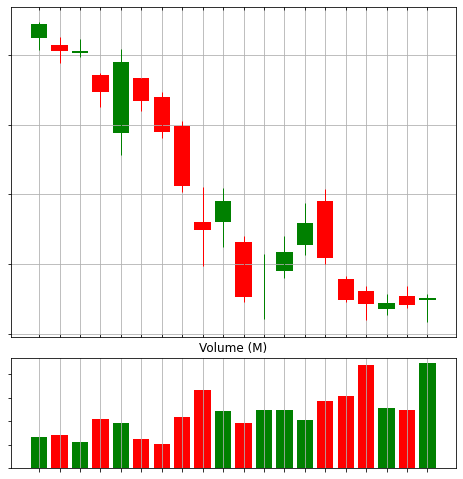

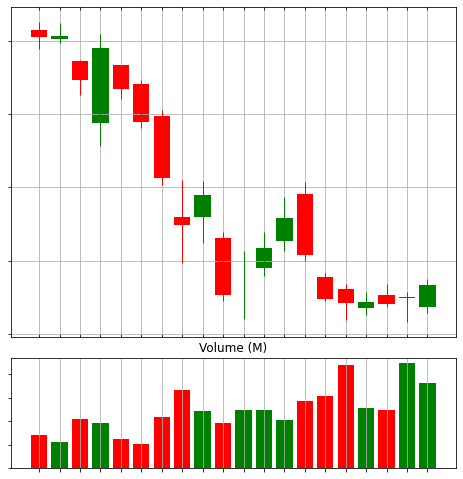

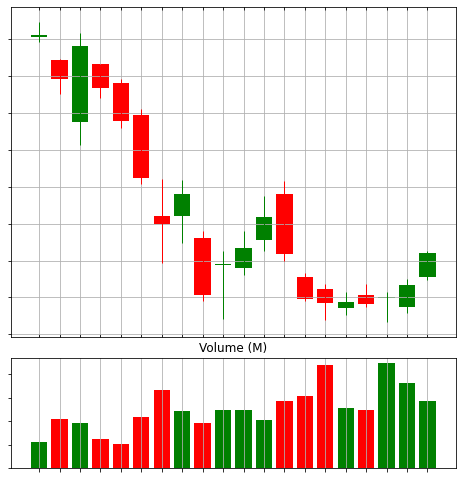

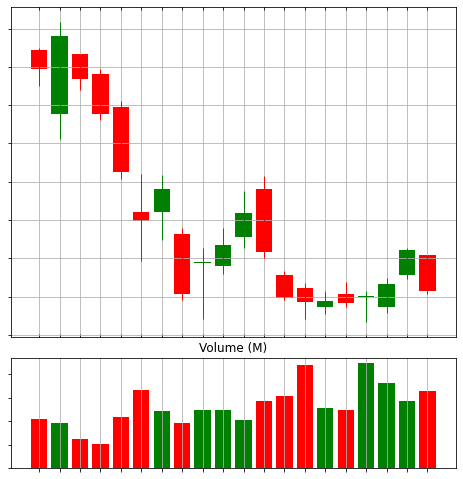

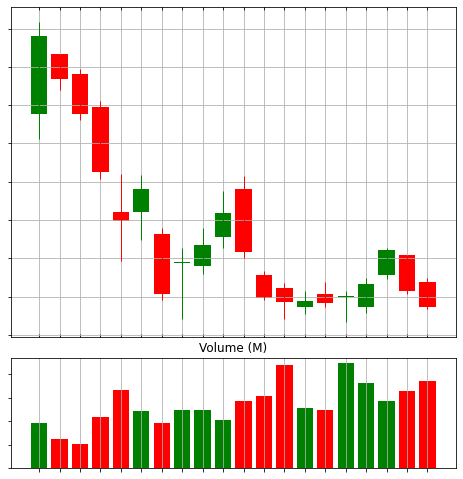

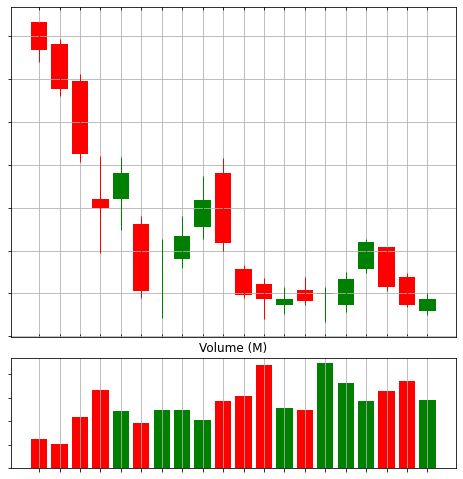

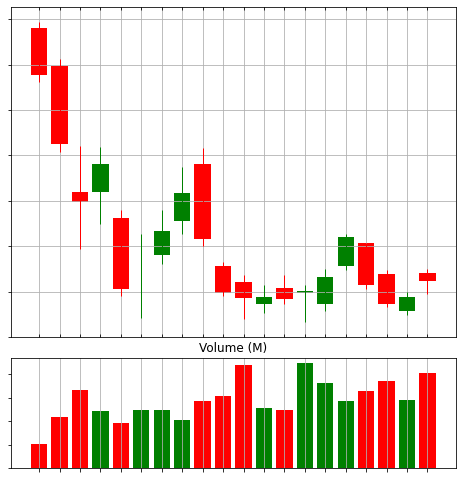

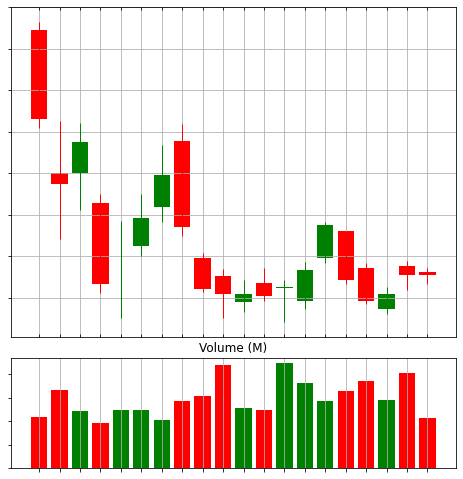

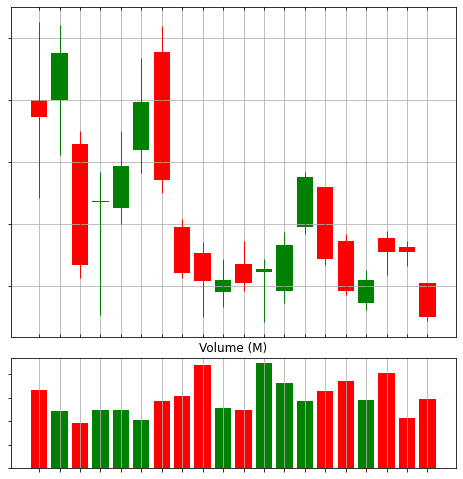

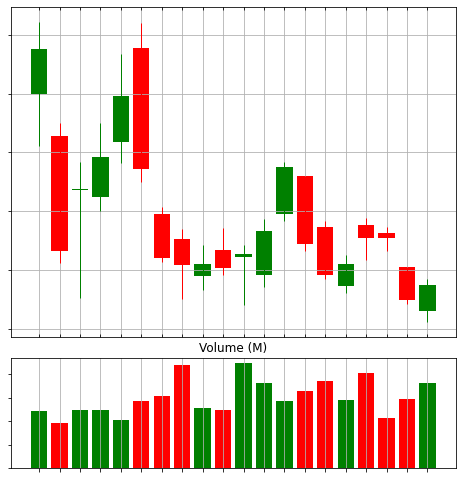

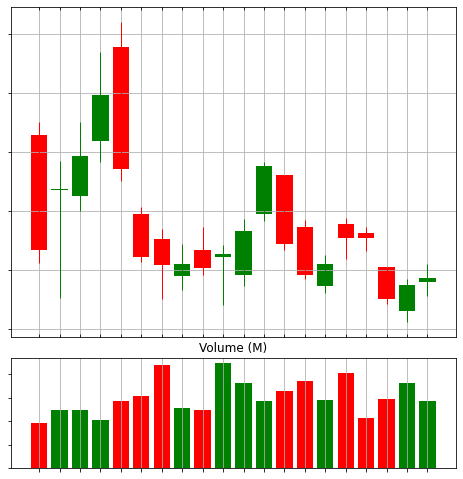

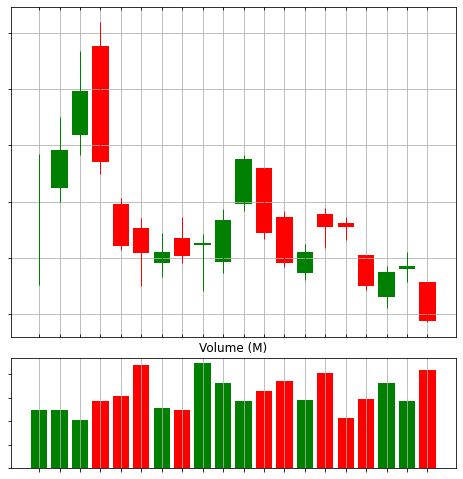

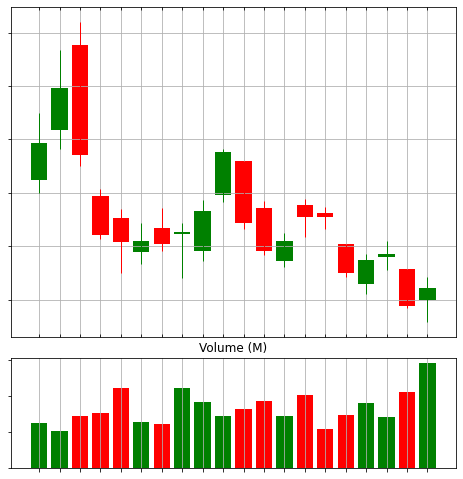

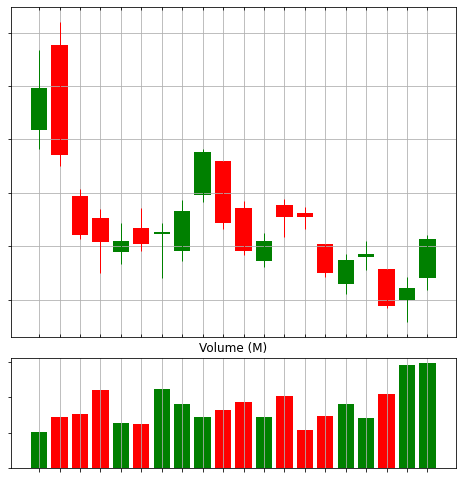

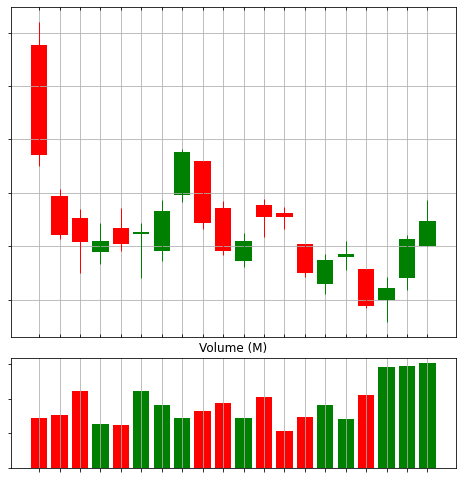

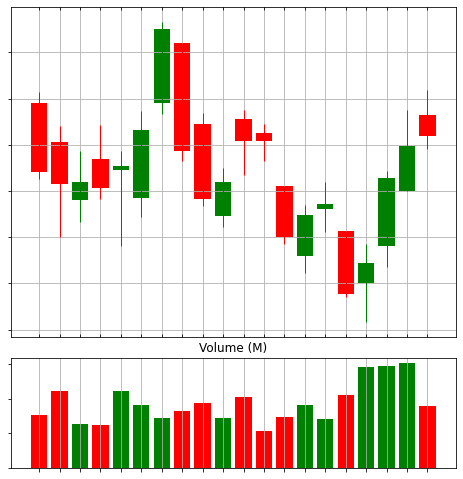

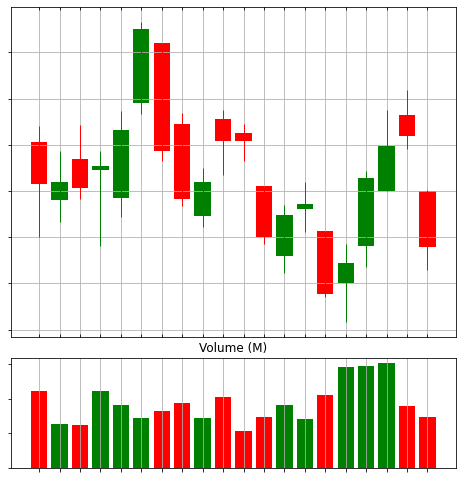

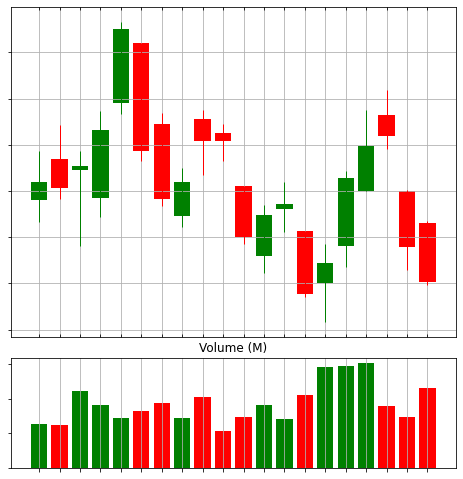

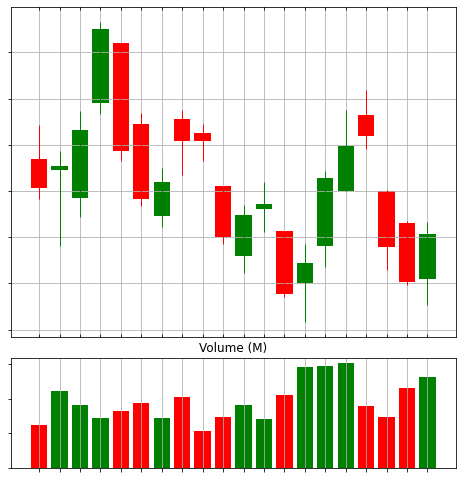

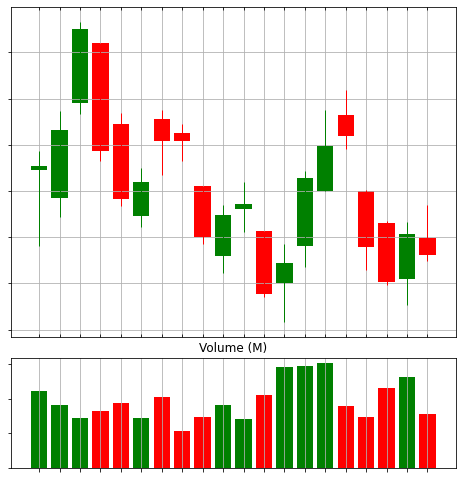

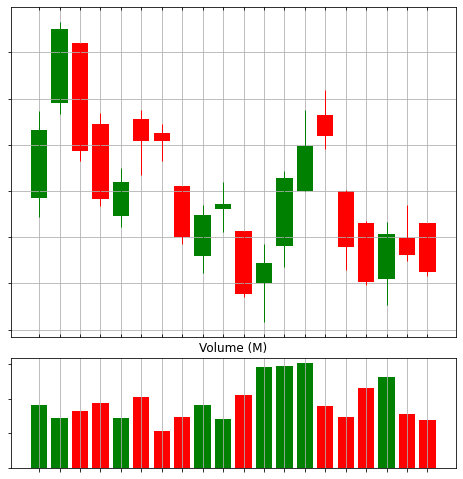

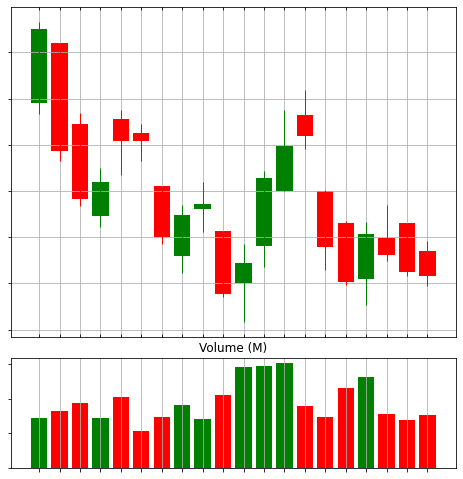

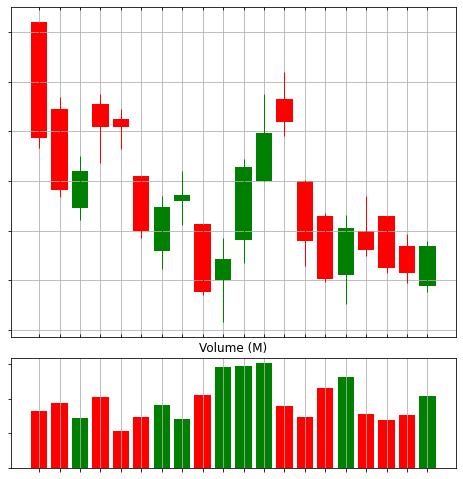

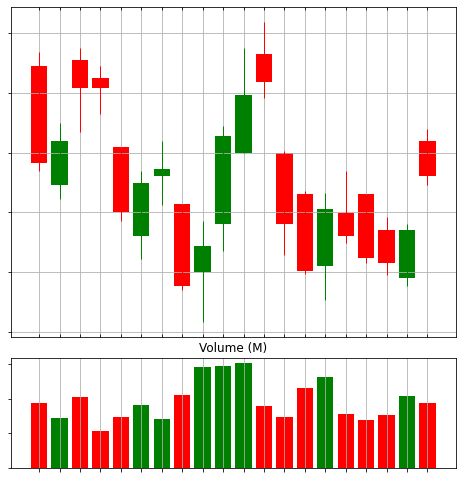

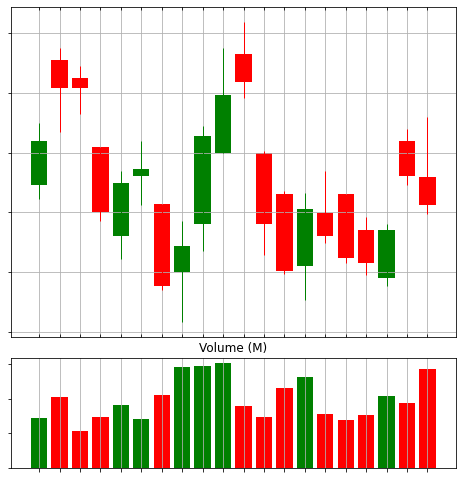

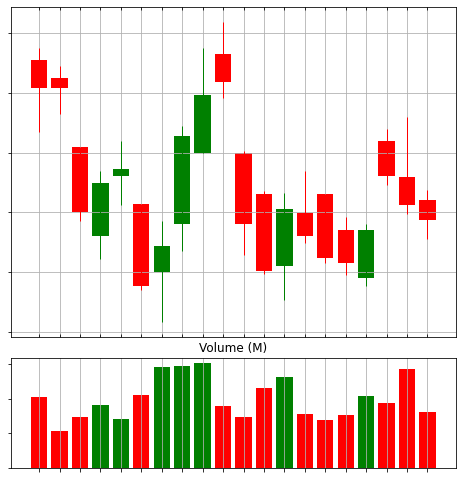

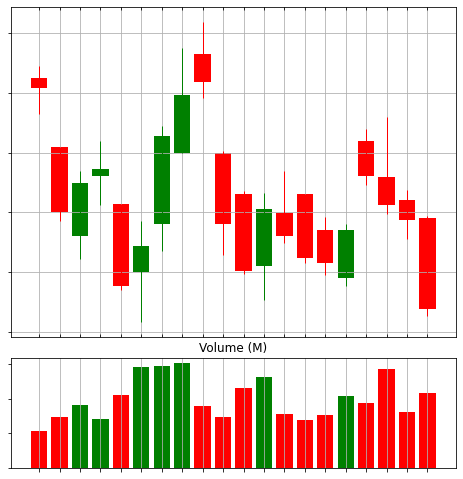

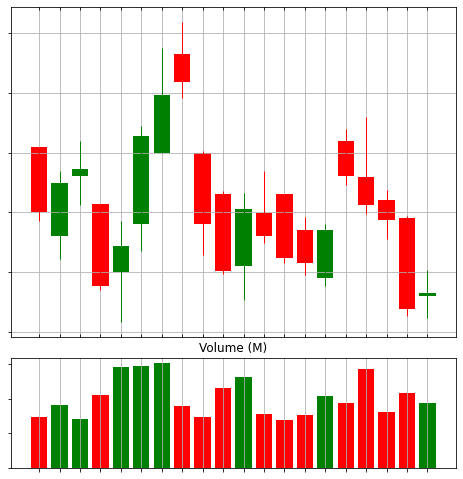

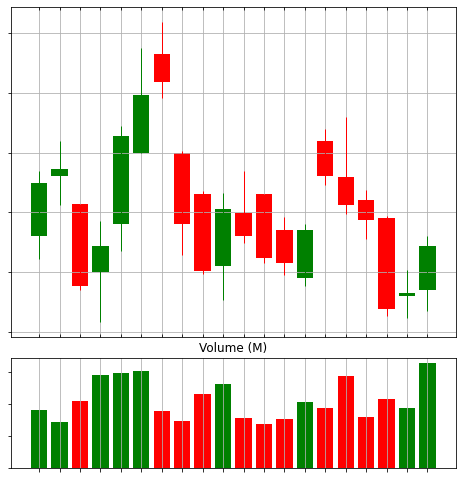

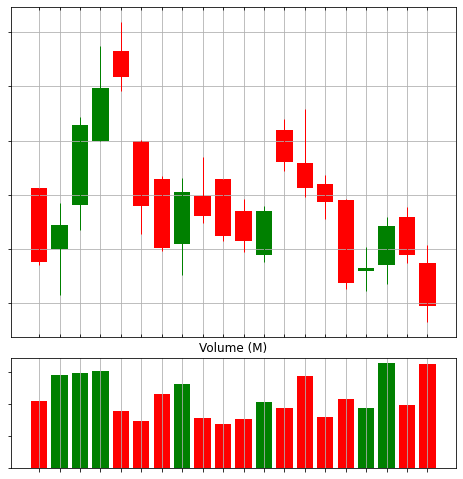

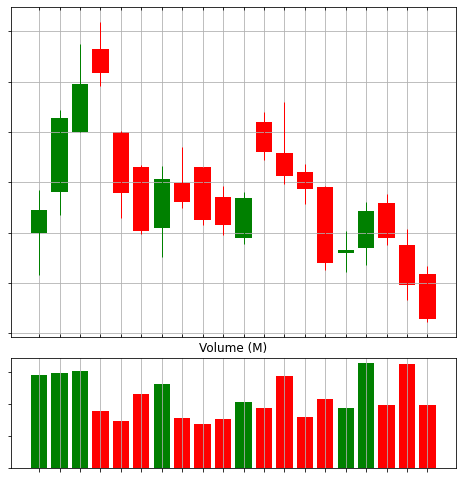

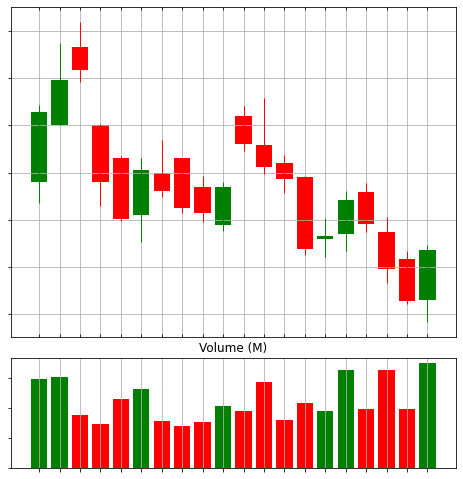

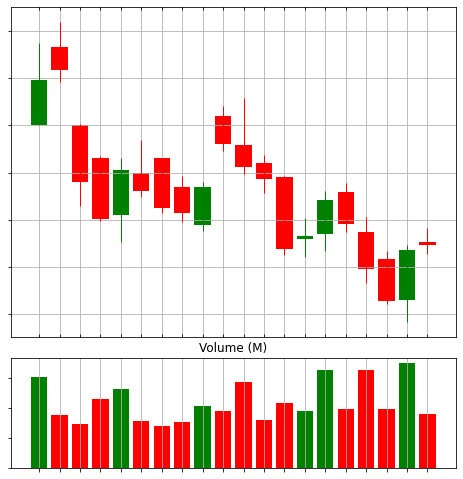

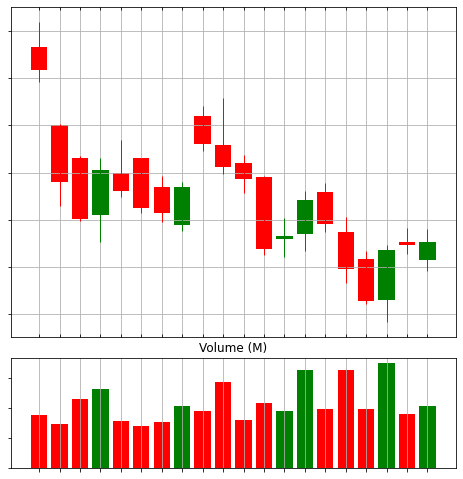

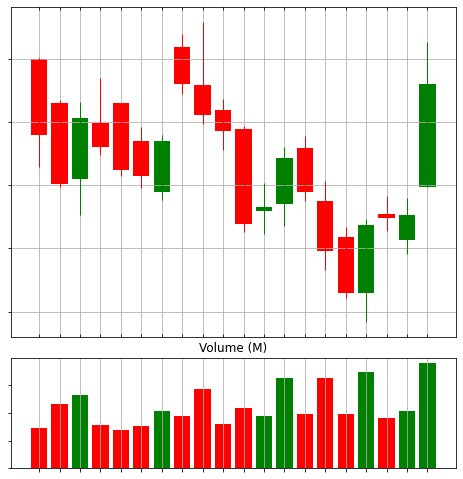

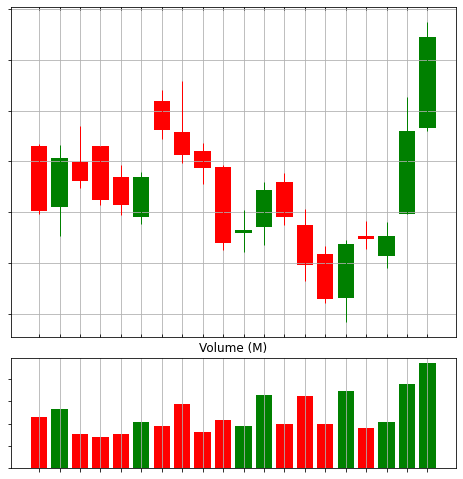

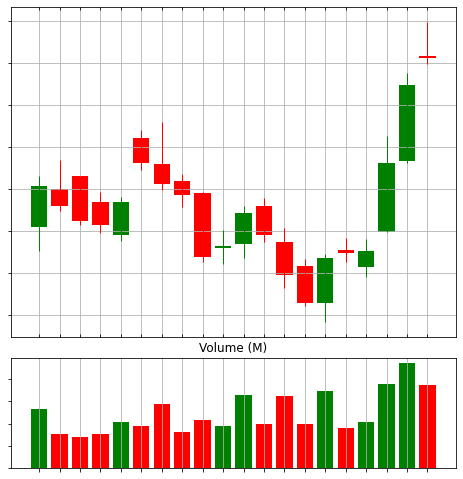

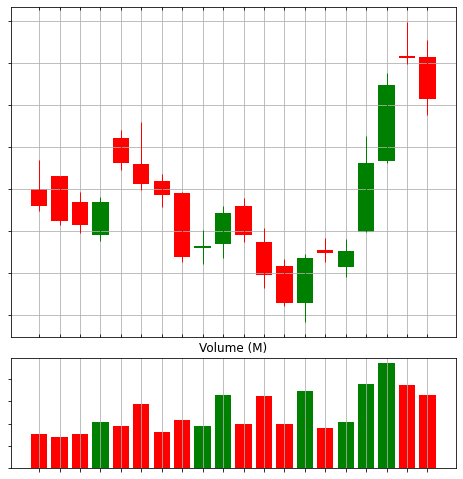

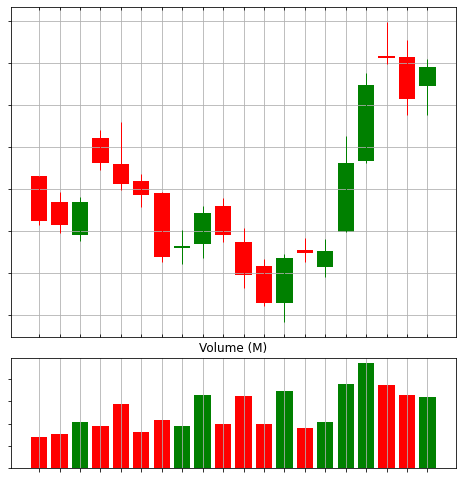

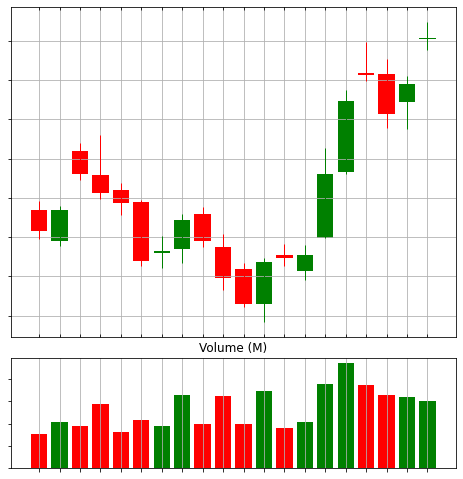

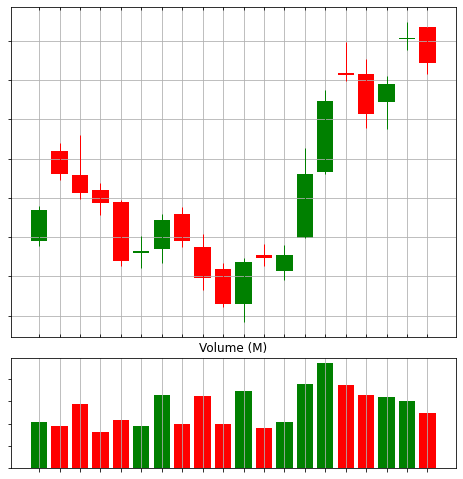

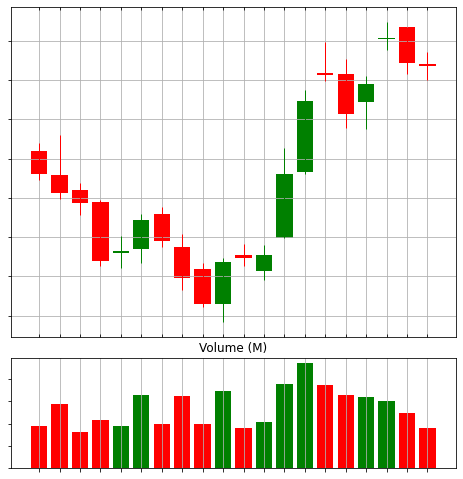

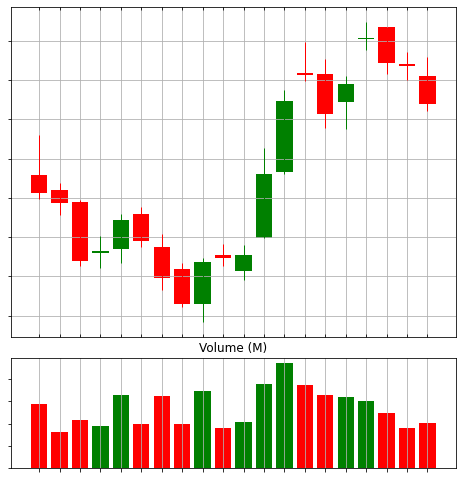

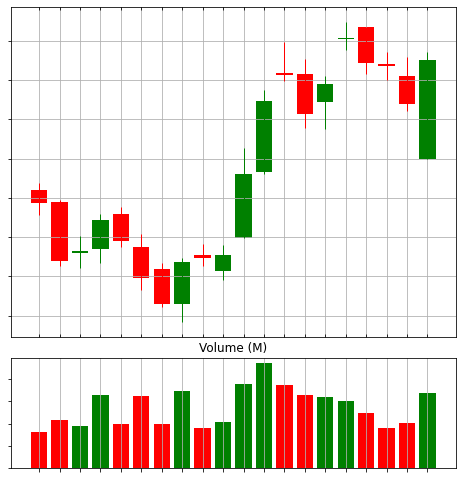

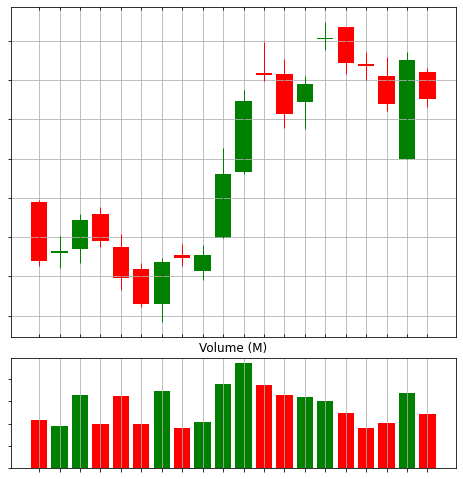

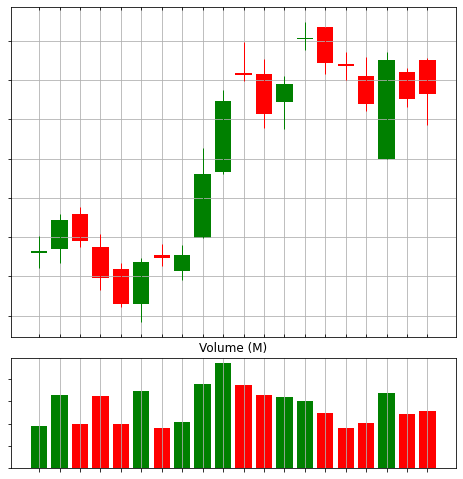

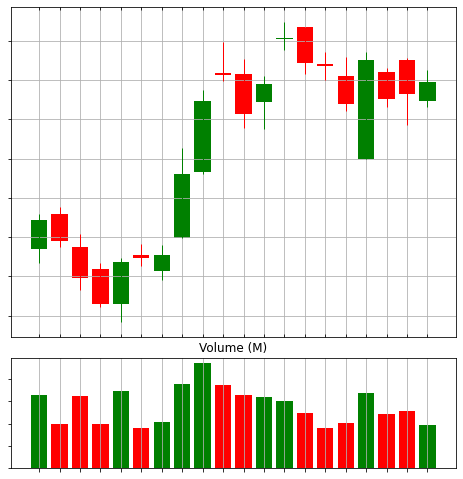

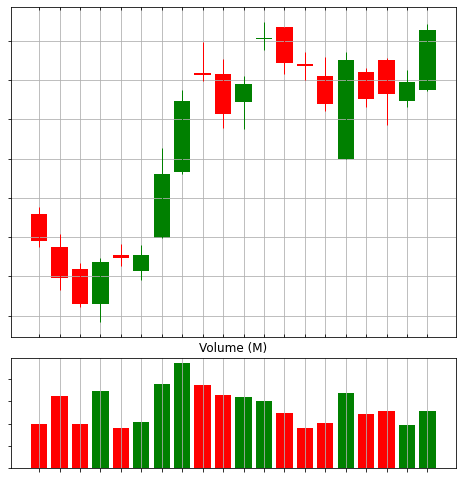

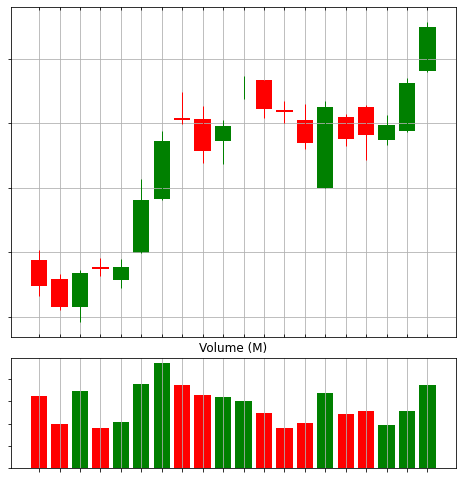

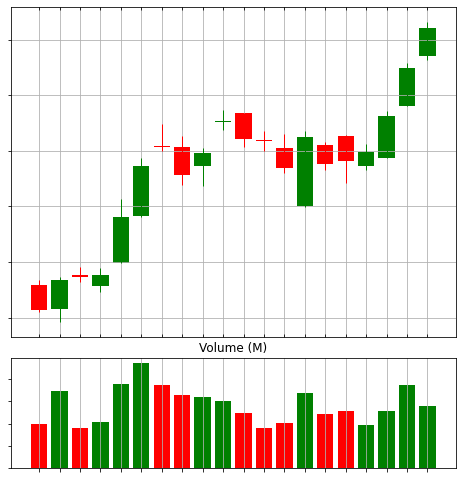

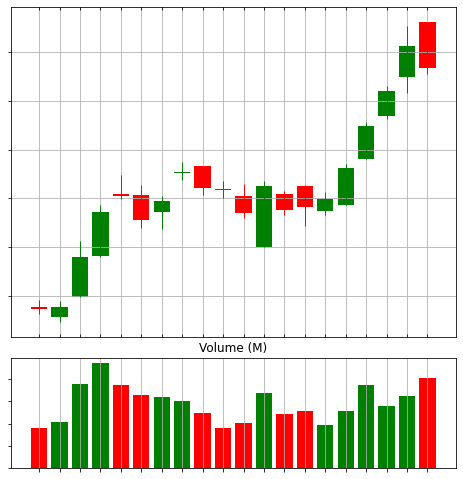

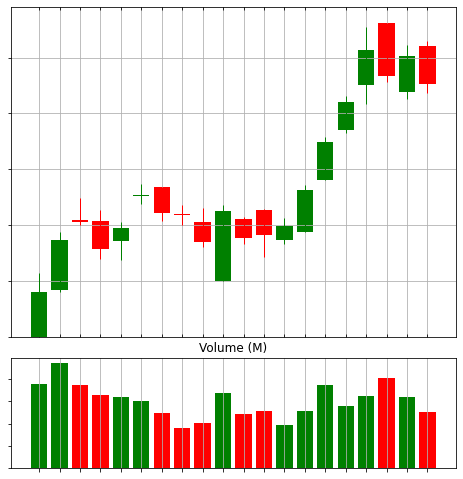

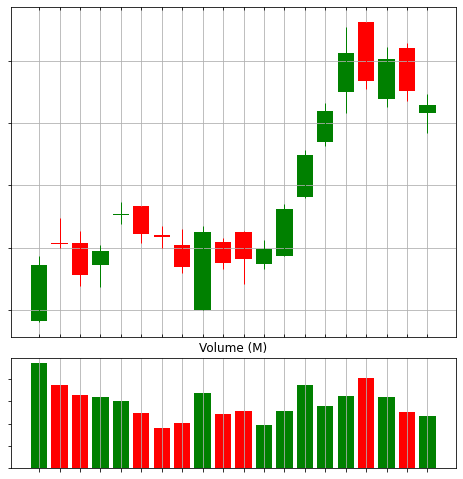

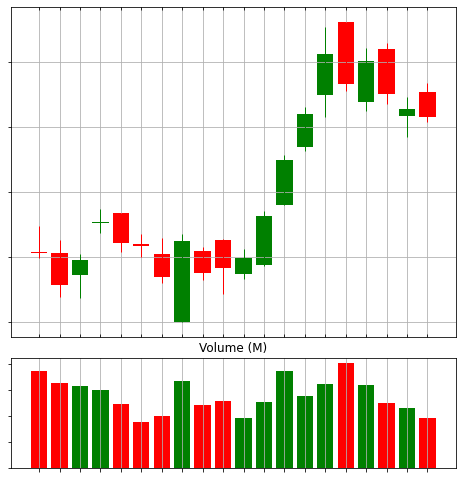

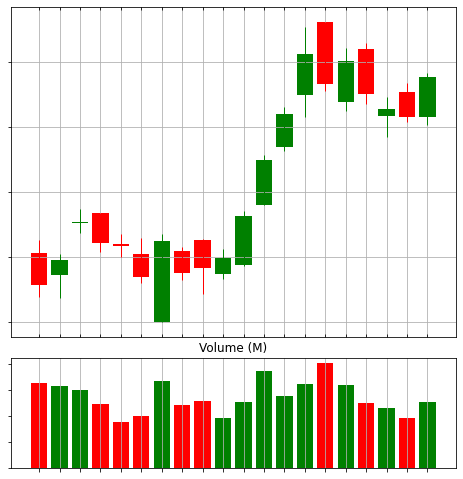

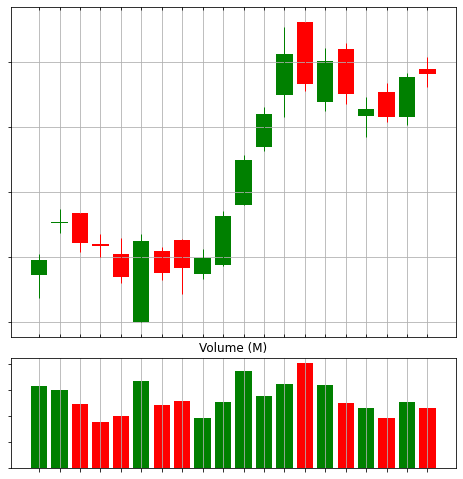

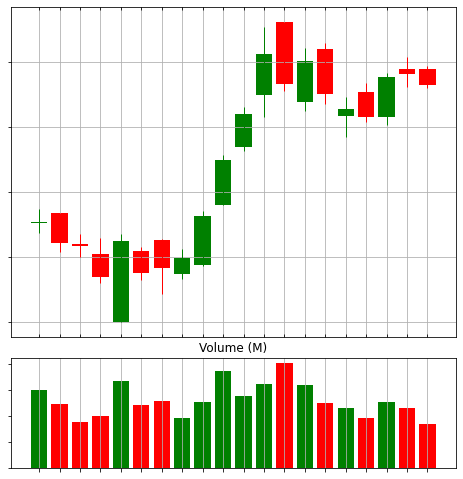

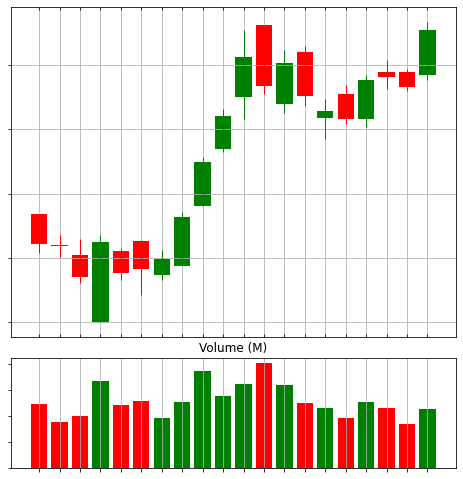

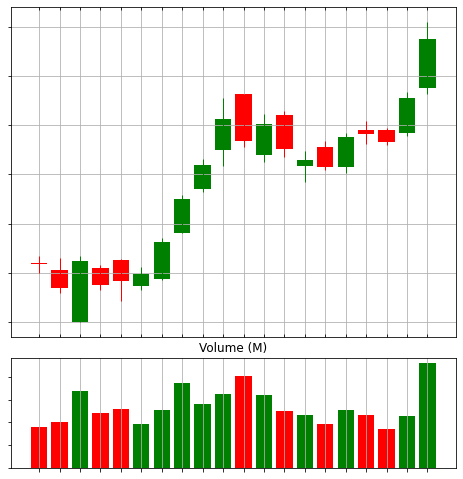

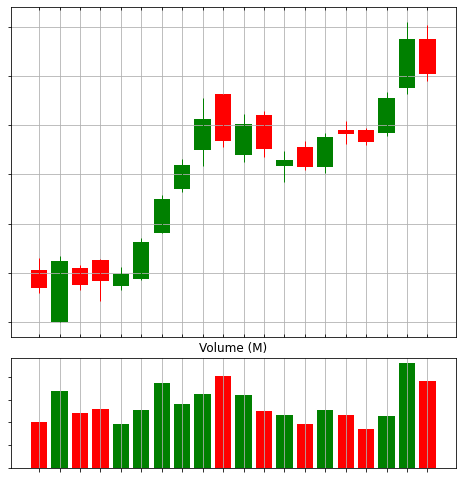

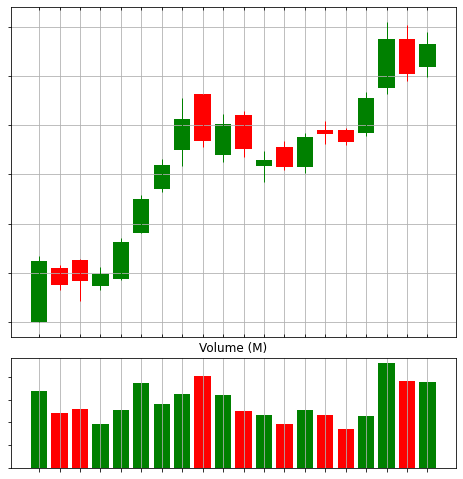

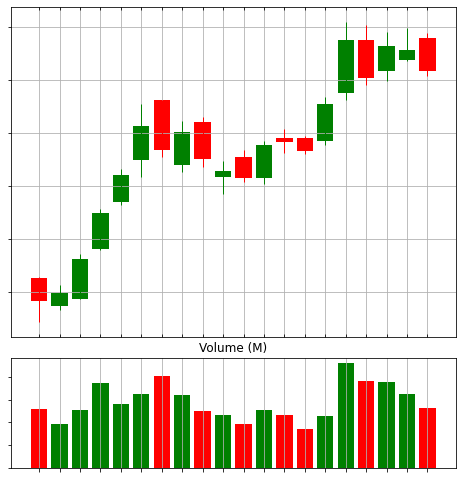

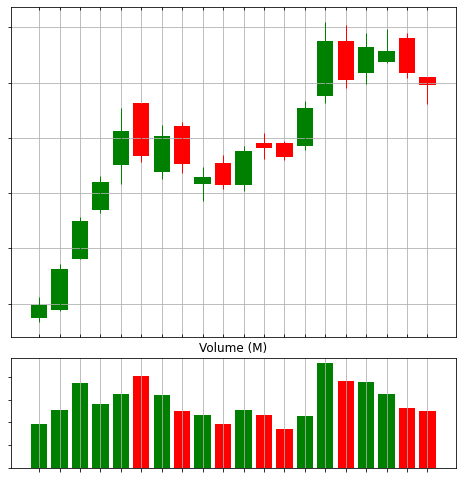

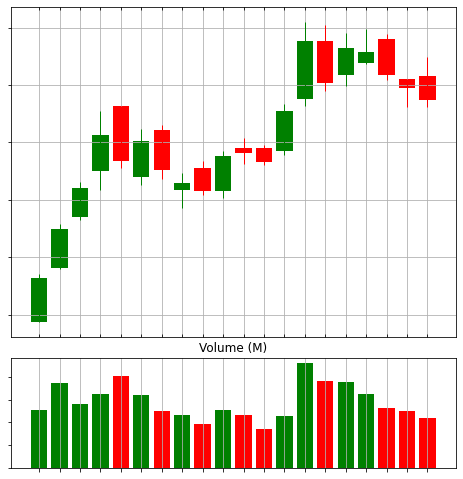

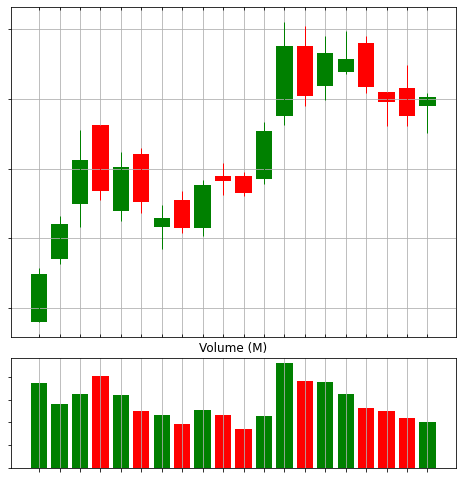

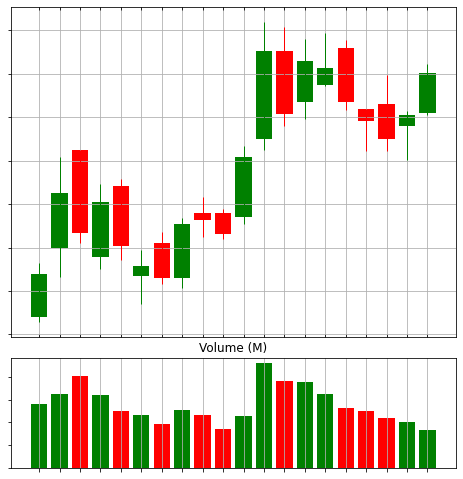

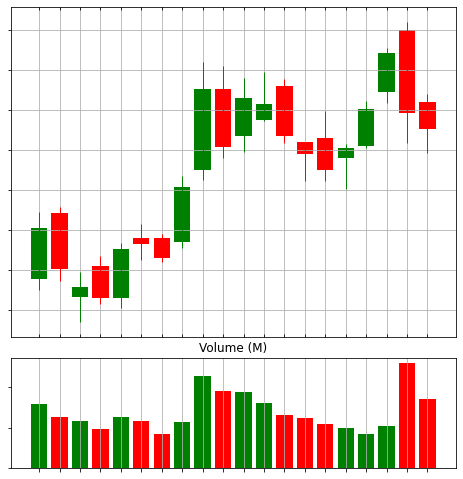

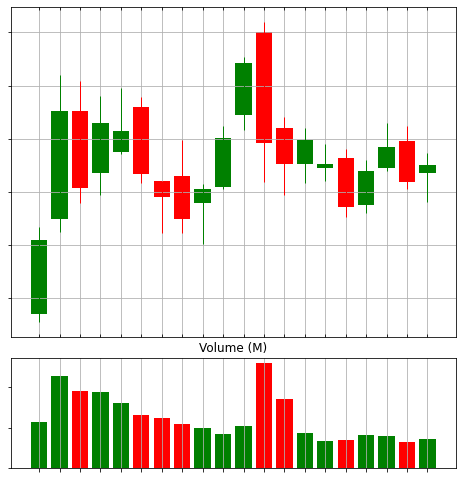

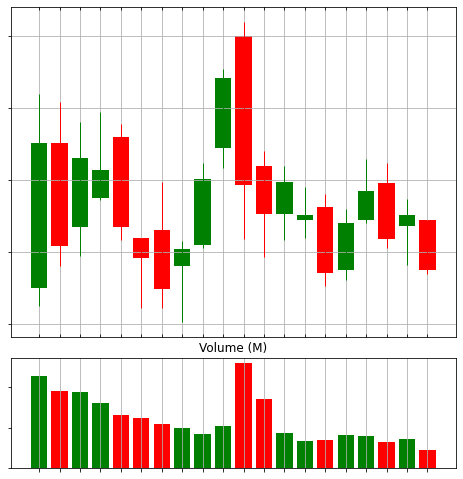

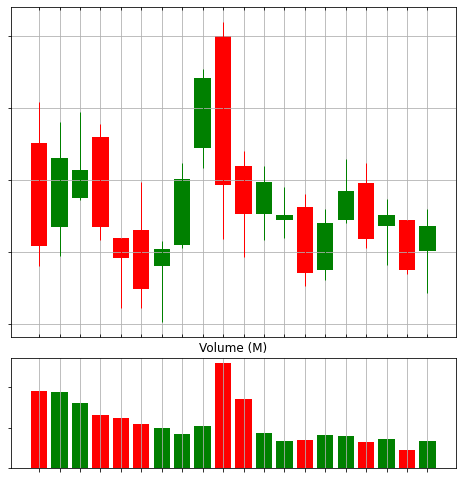

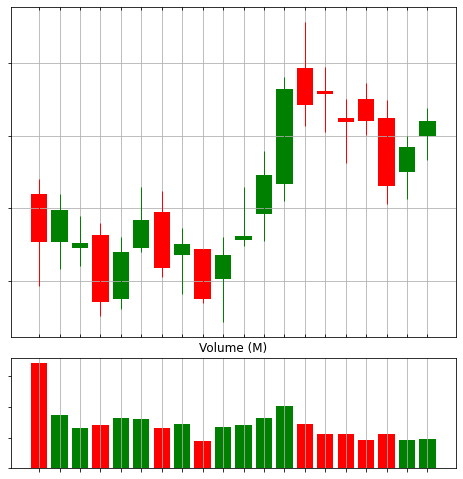

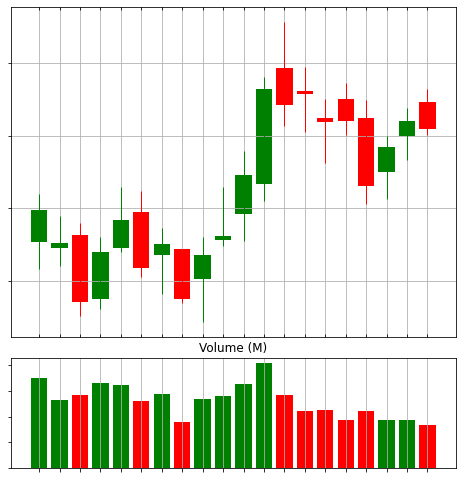

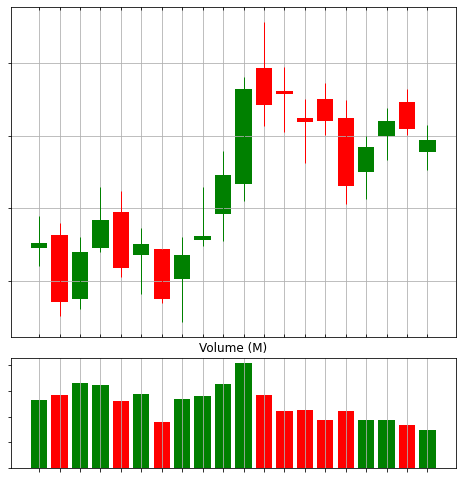

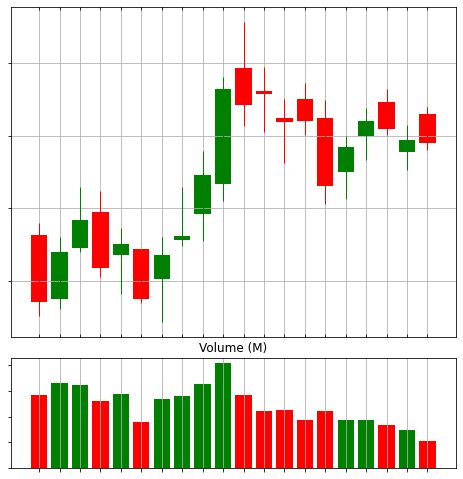

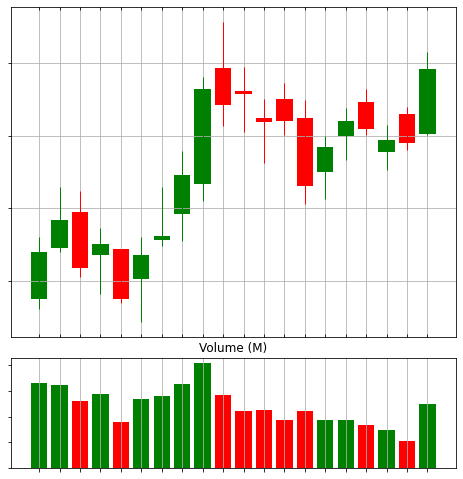

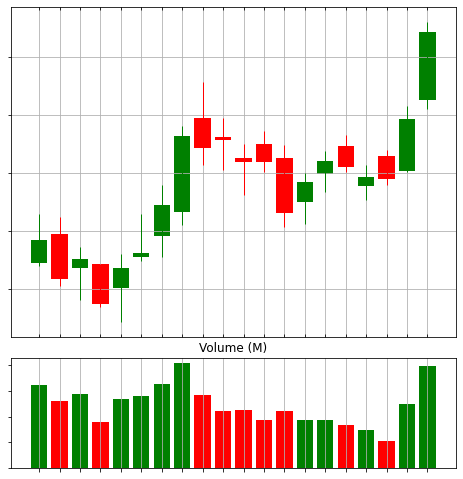

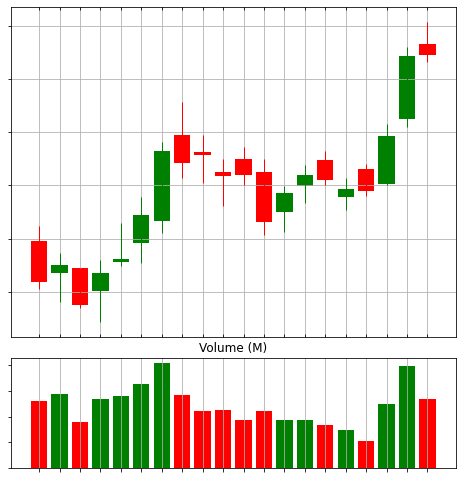

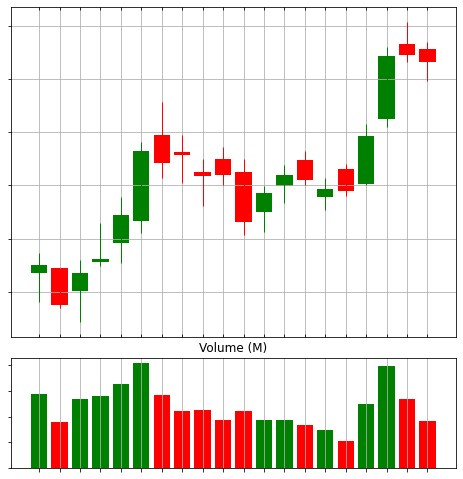

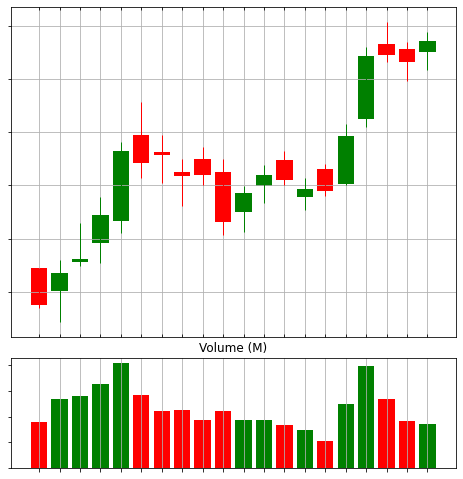

In [5]:
equities=['BAJFINANCE']
for equity in equities :
    df_pricing=obtain_data(equity,date(2019,1,1),date(2020,9,1))
    df=df_pricing.copy()
    df=df.reset_index(drop=True)
    n_days=5
    fraction_movement=0.037
    df['Trend']=None
    for i in range(len(df)):
        try :
            for n in range(n_days): 
                if  df.loc[i,'close_price'] - df.loc[i+n,'close_price'] >= fraction_movement*df.loc[i,'close_price']:
                    df.loc[i,'Trend'] ='Down'
                    if i >=20 :
                        fig=plot_candles(df_pricing[i-20:i],volume_bars=True)
                        fig.savefig('Candle Data/Down/{0}{1}.png'.format(df_pricing['Symbol'][i],i),dpi=70)
                    print('Down',i,n)
                    break
                elif df.loc[i+n,'close_price'] - df.loc[i,'close_price'] >= fraction_movement*df.loc[i,'close_price'] :
                    df.loc[i,'Trend']='Up'
                    if i >20 :    
                        fig=plot_candles(df_pricing[i-20:i],volume_bars=True)
                        fig.savefig('Candle Data/Up/{0}{1}.png'.format(df_pricing['Symbol'][i],i),dpi=70)
                    print('Up',i,n)
                    break
                else :
                    df.loc[i,'Trend']= 'No Trend'
        except :
            pass

In [6]:
df_pricing['Symbol'][i]

'BAJFINANCE'